In [1]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn import preprocessing
import wfdb
import copy as cp
import scipy.signal as signal
import scipy.stats as stats
from sklearn import preprocessing
from tqdm import tqdm
import os
import pathlib
import re
import pandas as pd
import pickle
import csv
import statistics

In [2]:
import timeit

import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats("retina")

from sklearn.preprocessing import PolynomialFeatures

import sklearn.linear_model as skl_lm
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn import neighbors
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis 
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.tree import DecisionTreeRegressor 
from sklearn.tree import DecisionTreeClassifier 
from sklearn.tree import export_graphviz
from sklearn.svm import SVC

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import mean_squared_error

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier

import xgboost as xgb
from xgboost import XGBClassifier
from sklearn import metrics
from lightgbm import LGBMClassifier

import lightgbm
import lightgbm as lgb
from sklearn.preprocessing import LabelBinarizer

import catboost as cb
from catboost import CatBoostClassifier

C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [3]:
parent_path = str(pathlib.Path(os.getcwd()).parent)

rlist = []
records = os.path.normpath(parent_path + '/mit-bih-dataframes/subject_list.csv')
with open(records) as rfile:
    recordreader = csv.reader(rfile, delimiter=' ', quotechar='|')
    for row in recordreader:
        rlist.append(row[0])

In [11]:
performance_dict = {
    "Avg Accuracy": [],
    "Std Accuracy": [],
    "Sensitivity": [],
    "Specificity": [],
    "Precision": [],
    "F1 score": [],
    "Run time": [],
}

In [4]:
feature_dfs = {}
for record in tqdm(rlist):
    feature_dfs[record] = pd.read_csv(os.path.normpath(parent_path + '/mit-bih-time-features/'+record+'.csv'), index_col=0, dtype={'subjectID': str})

combined_features = pd.concat([feature_dfs[key][1:] for key in feature_dfs])

100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 34.17it/s]


In [5]:
X = combined_features[['cov']]
y = combined_features['mappedLabel'].map({"Non-Afib": 0, "Afib": 1})
groups = combined_features['subjectID'].astype('int64')

logo = LeaveOneGroupOut()
splits = list(logo.split(X, y, groups=groups))

In [6]:
# Logistic regression
start_time = timeit.default_timer()

logreg = LogisticRegression(solver='liblinear')

acc_score = []
Truth = []
Output = []

for train, test in tqdm(splits):
    X_train = X.iloc[train]
    y_train = y.iloc[train]

    X_test = X.iloc[test]
    y_test = y.iloc[test]

    logreg.fit(X_train, y_train)
    pred_values = logreg.predict(X_test)

    acc = accuracy_score(y_test, pred_values)
    acc_score.append(acc)

    Truth.extend(y_test.values.reshape(y_test.shape[0])) 
    Output.extend(pred_values)

elapsed = timeit.default_timer() - start_time

print("---Run time is %s seconds ---" % elapsed)
print()
print('Accuracy of each fold: \n {}'.format(acc_score))
print("Avg accuracy: {}".format(np.mean(acc_score)))
print('Std of accuracy : \n{}'.format(np.std(acc_score)))
print("confusion matrix: ")

cm = confusion_matrix(Truth, Output)
print(cm)
print("classification report: ")
print(classification_report(Truth, Output))

sensitivity = cm[0][0]/(cm[0][0]+cm[0][1])
specificity = cm[1][1]/(cm[1][0]+cm[1][1])
precision = (cm[0][0])/(cm[0][0]+cm[1][0])
f1_score = (2*precision*sensitivity)/(precision+sensitivity)

print(sensitivity)
print(specificity)
print(precision)
print(f1_score)

100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:01<00:00, 14.95it/s]


---Run time is 1.5443559999985155 seconds ---

Accuracy of each fold: 
 [0.8952836637047163, 0.9133093874381129, 0.9880844645550528, 0.8193430656934306, 0.9923376460243688, 0.9200973236009732, 0.895987446760816, 0.9526927484039941, 0.9081374321880651, 0.7817413132514203, 0.9745938283720423, 0.9607741489545533, 0.909912854030501, 1.0, 0.1746633416458853, 0.903115663679044, 0.9392484687965569, 0.9915336571825122, 0.6193469884404786, 0.8994450317124736, 0.987845981002962, 0.9113560857746904, 0.9910155461336564]
Avg accuracy: 0.8839072211889699
Std of accuracy : 
0.1725228876399985
confusion matrix: 
[[91019 11866]
 [11879 72793]]
classification report: 
              precision    recall  f1-score   support

           0       0.88      0.88      0.88    102885
           1       0.86      0.86      0.86     84672

    accuracy                           0.87    187557
   macro avg       0.87      0.87      0.87    187557
weighted avg       0.87      0.87      0.87    187557

0.884667347037

In [7]:
# Linear discriminant analysis
start_time = timeit.default_timer()

lda = LinearDiscriminantAnalysis()

acc_score = []
Truth = []
Output = []

for train, test in tqdm(splits):
    X_train = X.iloc[train]
    y_train = y.iloc[train]

    X_test = X.iloc[test]
    y_test = y.iloc[test]

    lda.fit(X_train, y_train)
    pred_values = lda.predict(X_test)

    acc = accuracy_score(y_test, pred_values)
    acc_score.append(acc)

    Truth.extend(y_test.values.reshape(y_test.shape[0])) 
    Output.extend(pred_values)

elapsed = timeit.default_timer() - start_time

print("---Run time is %s seconds ---" % elapsed)
print()
print('Accuracy of each fold: \n {}'.format(acc_score))
print("Avg accuracy: {}".format(np.mean(acc_score)))
print('Std of accuracy : \n{}'.format(np.std(acc_score)))
print("confusion matrix: ")

cm = confusion_matrix(Truth, Output)
print(cm)
print("classification report: ")
print(classification_report(Truth, Output))

sensitivity = cm[0][0]/(cm[0][0]+cm[0][1])
specificity = cm[1][1]/(cm[1][0]+cm[1][1])
precision = (cm[0][0])/(cm[0][0]+cm[1][0])
f1_score = (2*precision*sensitivity)/(precision+sensitivity)

print(sensitivity)
print(specificity)
print(precision)
print(f1_score)

100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 25.02it/s]


---Run time is 0.9362617000006139 seconds ---

Accuracy of each fold: 
 [0.8967874231032126, 0.9130181535773226, 0.9882352941176471, 0.8248175182481752, 0.9919608089436001, 0.919610705596107, 0.8960995292535306, 0.952856441316091, 0.9066907775768536, 0.7872902629145198, 0.974266710282412, 0.9611197511664075, 0.9106753812636166, 0.9998467667790377, 0.2087780548628429, 0.902475458813487, 0.9404072173481212, 0.9904233171408744, 0.63192050294058, 0.8965380549682875, 0.9876417117761209, 0.9119601328903655, 0.9903089036947305]
Avg accuracy: 0.886249081677128
Std of accuracy : 
0.16530120516236047
confusion matrix: 
[[91314 11571]
 [11665 73007]]
classification report: 
              precision    recall  f1-score   support

           0       0.89      0.89      0.89    102885
           1       0.86      0.86      0.86     84672

    accuracy                           0.88    187557
   macro avg       0.87      0.87      0.87    187557
weighted avg       0.88      0.88      0.88    187557

0

In [8]:
# Quadratic discriminant analysis
start_time = timeit.default_timer()

qda = QuadraticDiscriminantAnalysis()

acc_score = []
Truth = []
Output = []

for train, test in tqdm(splits):
    X_train = X.iloc[train]
    y_train = y.iloc[train]

    X_test = X.iloc[test]
    y_test = y.iloc[test]

    qda.fit(X_train, y_train)
    pred_values = qda.predict(X_test)

    acc = accuracy_score(y_test, pred_values)
    acc_score.append(acc)

    Truth.extend(y_test.values.reshape(y_test.shape[0])) 
    Output.extend(pred_values)

elapsed = timeit.default_timer() - start_time

print("---Run time is %s seconds ---" % elapsed)
print()
print('Accuracy of each fold: \n {}'.format(acc_score))
print("Avg accuracy: {}".format(np.mean(acc_score)))
print('Std of accuracy : \n{}'.format(np.std(acc_score)))
print("confusion matrix: ")

cm = confusion_matrix(Truth, Output)
print(cm)
print("classification report: ")
print(classification_report(Truth, Output))

sensitivity = cm[0][0]/(cm[0][0]+cm[0][1])
specificity = cm[1][1]/(cm[1][0]+cm[1][1])
precision = (cm[0][0])/(cm[0][0]+cm[1][0])
f1_score = (2*precision*sensitivity)/(precision+sensitivity)

print(sensitivity)
print(specificity)
print(precision)
print(f1_score)

100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 64.43it/s]


---Run time is 0.3609729000017978 seconds ---

Accuracy of each fold: 
 [0.8985645933014355, 0.9108824385981944, 0.9897435897435898, 0.8311341942728804, 0.9920864213038563, 0.9197080291970803, 0.8932974669356647, 0.9531838271402848, 0.9024713682941531, 0.7945567446161976, 0.9741576709192018, 0.9614653533782617, 0.9113289760348584, 0.9998467667790377, 0.16658354114713217, 0.8971404182671788, 0.9425591789438834, 0.9887578070784178, 0.6425674305414724, 0.8880813953488372, 0.9876417117761209, 0.912262156448203, 0.9882899252977994]
Avg accuracy: 0.8846222176245107
Std of accuracy : 
0.17186400068958949
confusion matrix: 
[[91689 11196]
 [12437 72235]]
classification report: 
              precision    recall  f1-score   support

           0       0.88      0.89      0.89    102885
           1       0.87      0.85      0.86     84672

    accuracy                           0.87    187557
   macro avg       0.87      0.87      0.87    187557
weighted avg       0.87      0.87      0.87    18

In [9]:
# KNN-CV (k = 3, 5, 10)
for k in [3, 5, 10]:
    print('k is: ' + str(k))
    start_time = timeit.default_timer()

    knn = neighbors.KNeighborsClassifier(n_neighbors = k)

    acc_score = []
    Truth = []
    Output = []

    for train, test in tqdm(splits):
        X_train = X.iloc[train]
        y_train = y.iloc[train]

        X_test = X.iloc[test]
        y_test = y.iloc[test]

        knn.fit(X_train, y_train)
        pred_values = knn.predict(X_test)

        acc = accuracy_score(y_test, pred_values)
        acc_score.append(acc)

        Truth.extend(y_test.values.reshape(y_test.shape[0])) 
        Output.extend(pred_values)

    elapsed = timeit.default_timer() - start_time

    print("---Run time is %s seconds ---" % elapsed)
    print()
    print('Accuracy of each fold: \n {}'.format(acc_score))
    print("Avg accuracy: {}".format(np.mean(acc_score)))
    print('Std of accuracy : \n{}'.format(np.std(acc_score)))
    print("confusion matrix: ")

    cm = confusion_matrix(Truth, Output)
    print(cm)
    print("classification report: ")
    print(classification_report(Truth, Output))

    sensitivity = cm[0][0]/(cm[0][0]+cm[0][1])
    specificity = cm[1][1]/(cm[1][0]+cm[1][1])
    precision = (cm[0][0])/(cm[0][0]+cm[1][0])
    f1_score = (2*precision*sensitivity)/(precision+sensitivity)

    print(sensitivity)
    print(specificity)
    print(precision)
    print(f1_score)

k is: 3


100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:05<00:00,  4.36it/s]


---Run time is 5.293569200002821 seconds ---

Accuracy of each fold: 
 [0.8809295967190705, 0.9041840598000194, 0.9852187028657617, 0.723469960696238, 0.9748775279487502, 0.9127007299270073, 0.8790629903609056, 0.9589130790636765, 0.8819770946353225, 0.742634429911481, 0.9435176098571584, 0.9593917401071367, 0.8010893246187364, 0.941618142813362, 0.3481296758104738, 0.8855100298762271, 0.9170667108094687, 0.9535045107564192, 0.5498884607584669, 0.9097515856236786, 0.9415790011234807, 0.9205678042887345, 0.9567938623056733]
Avg accuracy: 0.8640163752468367
Std of accuracy : 
0.1469550560821928
confusion matrix: 
[[87988 14897]
 [12435 72237]]
classification report: 
              precision    recall  f1-score   support

           0       0.88      0.86      0.87    102885
           1       0.83      0.85      0.84     84672

    accuracy                           0.85    187557
   macro avg       0.85      0.85      0.85    187557
weighted avg       0.85      0.85      0.85    187557


100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:05<00:00,  4.35it/s]


---Run time is 5.29682230000617 seconds ---

Accuracy of each fold: 
 [0.8816131237183868, 0.910299970876614, 0.9859728506787331, 0.7244525547445255, 0.9836703931666876, 0.9139659367396593, 0.8922887245012329, 0.958094614503192, 0.9027124773960217, 0.7415774871185097, 0.9628175771453494, 0.9611197511664075, 0.8132897603485839, 0.9593931964449893, 0.3295760598503741, 0.902475458813487, 0.915742426750538, 0.9715475364330326, 0.544311498681809, 0.9178118393234672, 0.9642528853028292, 0.9204167925098158, 0.9759741570765192]
Avg accuracy: 0.8710163944909027
Std of accuracy : 
0.15346715171713615
confusion matrix: 
[[87796 15089]
 [10876 73796]]
classification report: 
              precision    recall  f1-score   support

           0       0.89      0.85      0.87    102885
           1       0.83      0.87      0.85     84672

    accuracy                           0.86    187557
   macro avg       0.86      0.86      0.86    187557
weighted avg       0.86      0.86      0.86    187557

0

100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:05<00:00,  4.30it/s]


---Run time is 5.362440500000957 seconds ---

Accuracy of each fold: 
 [0.8842105263157894, 0.9106882826910009, 0.98763197586727, 0.7438236945536215, 0.9885692752166814, 0.9147445255474452, 0.8955391167899575, 0.9621869373056147, 0.9080168776371308, 0.7501651473114018, 0.967942427216225, 0.9675133920857093, 0.8361655773420479, 0.9613852283174993, 0.26663341645885286, 0.9068501920614597, 0.9198808144346963, 0.978764746703678, 0.5515108497262219, 0.9186046511627907, 0.9730364620569911, 0.9228329809725159, 0.9816272965879265]
Avg accuracy: 0.8738401910592405
Std of accuracy : 
0.1628928721187628
confusion matrix: 
[[88536 14349]
 [11205 73467]]
classification report: 
              precision    recall  f1-score   support

           0       0.89      0.86      0.87    102885
           1       0.84      0.87      0.85     84672

    accuracy                           0.86    187557
   macro avg       0.86      0.86      0.86    187557
weighted avg       0.86      0.86      0.86    187557


In [10]:
# Decision tree
start_time = timeit.default_timer()

decisionTree = DecisionTreeClassifier(max_depth=6) #criterion='entropy'

acc_score = []
Truth = []
Output = []

for train, test in tqdm(splits):
    X_train = X.iloc[train]
    y_train = y.iloc[train]

    X_test = X.iloc[test]
    y_test = y.iloc[test]

    decisionTree.fit(X_train, y_train)
    pred_values = decisionTree.predict(X_test)

    acc = accuracy_score(y_test, pred_values)
    acc_score.append(acc)

    Truth.extend(y_test.values.reshape(y_test.shape[0])) 
    Output.extend(pred_values)

elapsed = timeit.default_timer() - start_time

print("---Run time is %s seconds ---" % elapsed)
print()
print('Accuracy of each fold: \n {}'.format(acc_score))
print("Avg accuracy: {}".format(np.mean(acc_score)))
print('Std of accuracy : \n{}'.format(np.std(acc_score)))
print("confusion matrix: ")

cm = confusion_matrix(Truth, Output)
print(cm)
print("classification report: ")
print(classification_report(Truth, Output))

sensitivity = cm[0][0]/(cm[0][0]+cm[0][1])
specificity = cm[1][1]/(cm[1][0]+cm[1][1])
precision = (cm[0][0])/(cm[0][0]+cm[1][0])
f1_score = (2*precision*sensitivity)/(precision+sensitivity)

print(sensitivity)
print(specificity)
print(precision)
print(f1_score)

100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:03<00:00,  6.76it/s]


---Run time is 3.4204968999983976 seconds ---

Accuracy of each fold: 
 [0.8780587833219412, 0.920299000097078, 0.9873303167420815, 0.7081695676586187, 0.9907046853410375, 0.9158150851581508, 0.9088769334229994, 0.9634964806023899, 0.9305605786618445, 0.72294887039239, 0.968814742121906, 0.9635389666493865, 0.8269063180827887, 0.974869751762182, 0.27581047381546137, 0.9416346564233888, 0.9119351100811124, 0.9938931297709923, 0.5211924558912999, 0.9433139534883721, 0.9917270963129404, 0.926457263666566, 0.9961639410458308]
Avg accuracy: 0.8766312243700329
Std of accuracy : 
0.16957563398597278
confusion matrix: 
[[87132 15753]
 [ 9161 75511]]
classification report: 
              precision    recall  f1-score   support

           0       0.90      0.85      0.87    102885
           1       0.83      0.89      0.86     84672

    accuracy                           0.87    187557
   macro avg       0.87      0.87      0.87    187557
weighted avg       0.87      0.87      0.87    187557


In [11]:
# bagging
start_time = timeit.default_timer()

bagging = RandomForestClassifier(max_features = 1, random_state = 2)

acc_score = []
Truth = []
Output = []

for train, test in tqdm(splits):
    X_train = X.iloc[train]
    y_train = y.iloc[train]

    X_test = X.iloc[test]
    y_test = y.iloc[test]

    bagging.fit(X_train, y_train)
    pred_values = bagging.predict(X_test)

    acc = accuracy_score(y_test, pred_values)
    acc_score.append(acc)

    Truth.extend(y_test.values.reshape(y_test.shape[0])) 
    Output.extend(pred_values)

elapsed = timeit.default_timer() - start_time

print("---Run time is %s seconds ---" % elapsed)
print()
print('Accuracy of each fold: \n {}'.format(acc_score))
print("Avg accuracy: {}".format(np.mean(acc_score)))
print('Std of accuracy : \n{}'.format(np.std(acc_score)))
print("confusion matrix: ")

cm = confusion_matrix(Truth, Output)
print(cm)
print("classification report: ")
print(classification_report(Truth, Output))

sensitivity = cm[0][0]/(cm[0][0]+cm[0][1])
specificity = cm[1][1]/(cm[1][0]+cm[1][1])
precision = (cm[0][0])/(cm[0][0]+cm[1][0])
f1_score = (2*precision*sensitivity)/(precision+sensitivity)

print(sensitivity)
print(specificity)
print(precision)
print(f1_score)

100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [10:04<00:00, 26.28s/it]


---Run time is 604.3824349999923 seconds ---

Accuracy of each fold: 
 [0.8818865345181135, 0.8955441219299097, 0.9812971342383107, 0.7161706906232453, 0.9324205501821379, 0.908418491484185, 0.8407307778524994, 0.9540022917007693, 0.8361663652802893, 0.7456731404412736, 0.8838730781812234, 0.9466044582685329, 0.7620915032679738, 0.8826233527428746, 0.37566084788029924, 0.8459240290226205, 0.9084588644264194, 0.9002081887578071, 0.5604339890488744, 0.8961416490486258, 0.8967419058318864, 0.9155844155844156, 0.9081364829396326]
Avg accuracy: 0.8423822984022575
Std of accuracy : 
0.13435147406494818
confusion matrix: 
[[88050 14835]
 [16616 68056]]
classification report: 
              precision    recall  f1-score   support

           0       0.84      0.86      0.85    102885
           1       0.82      0.80      0.81     84672

    accuracy                           0.83    187557
   macro avg       0.83      0.83      0.83    187557
weighted avg       0.83      0.83      0.83    187

In [12]:
# AdaBoost
start_time = timeit.default_timer()

adaBoost = AdaBoostClassifier(n_estimators=500, learning_rate = 0.1, algorithm="SAMME.R", random_state=2)

acc_score = []
Truth = []
Output = []

for train, test in tqdm(splits):
    X_train = X.iloc[train]
    y_train = y.iloc[train]

    X_test = X.iloc[test]
    y_test = y.iloc[test]

    adaBoost.fit(X_train, y_train)
    pred_values = adaBoost.predict(X_test)

    acc = accuracy_score(y_test, pred_values)
    acc_score.append(acc)

    Truth.extend(y_test.values.reshape(y_test.shape[0])) 
    Output.extend(pred_values)

elapsed = timeit.default_timer() - start_time

print("---Run time is %s seconds ---" % elapsed)
print()
print('Accuracy of each fold: \n {}'.format(acc_score))
print("Avg accuracy: {}".format(np.mean(acc_score)))
print('Std of accuracy : \n{}'.format(np.std(acc_score)))
print("confusion matrix: ")

cm = confusion_matrix(Truth, Output)
print(cm)
print("classification report: ")
print(classification_report(Truth, Output))

sensitivity = cm[0][0]/(cm[0][0]+cm[0][1])
specificity = cm[1][1]/(cm[1][0]+cm[1][1])
precision = (cm[0][0])/(cm[0][0]+cm[1][0])
f1_score = (2*precision*sensitivity)/(precision+sensitivity)

print(sensitivity)
print(specificity)
print(precision)
print(f1_score)

100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [08:26<00:00, 22.04s/it]


---Run time is 506.81416389999504 seconds ---

Accuracy of each fold: 
 [0.872863978127136, 0.919910688282691, 0.9868778280542987, 0.6855699045480067, 0.9910815224218064, 0.9133819951338199, 0.9080923559739968, 0.9612047798330332, 0.931163351416516, 0.7336504161712247, 0.9695780176643768, 0.9597373423189909, 0.7958605664488018, 0.9762488507508428, 0.27491271820448876, 0.9405676483141272, 0.9150802847210727, 0.9938931297709923, 0.5062867572500507, 0.9459566596194503, 0.9913185578592585, 0.9247961340984597, 0.9955582475267515]
Avg accuracy: 0.8736344232395737
Std of accuracy : 
0.17210985697312217
confusion matrix: 
[[86474 16411]
 [ 9105 75567]]
classification report: 
              precision    recall  f1-score   support

           0       0.90      0.84      0.87    102885
           1       0.82      0.89      0.86     84672

    accuracy                           0.86    187557
   macro avg       0.86      0.87      0.86    187557
weighted avg       0.87      0.86      0.86    1875

In [13]:
# Gradient boost (sklearn)
start_time = timeit.default_timer()

gradientBoost = GradientBoostingClassifier(n_estimators = 500, 
                                           learning_rate = 0.1, 
                                           max_depth = 4, 
                                           random_state = 2)

acc_score = []
Truth = []
Output = []

for train, test in tqdm(splits):
    X_train = X.iloc[train]
    y_train = y.iloc[train]

    X_test = X.iloc[test]
    y_test = y.iloc[test]

    gradientBoost.fit(X_train, y_train)
    pred_values = gradientBoost.predict(X_test)

    acc = accuracy_score(y_test, pred_values)
    acc_score.append(acc)

    Truth.extend(y_test.values.reshape(y_test.shape[0])) 
    Output.extend(pred_values)

elapsed = timeit.default_timer() - start_time

print("---Run time is %s seconds ---" % elapsed)
print()
print('Accuracy of each fold: \n {}'.format(acc_score))
print("Avg accuracy: {}".format(np.mean(acc_score)))
print('Std of accuracy : \n{}'.format(np.std(acc_score)))
print("confusion matrix: ")

cm = confusion_matrix(Truth, Output)
print(cm)
print("classification report: ")
print(classification_report(Truth, Output))

sensitivity = cm[0][0]/(cm[0][0]+cm[0][1])
specificity = cm[1][1]/(cm[1][0]+cm[1][1])
precision = (cm[0][0])/(cm[0][0]+cm[1][0])
f1_score = (2*precision*sensitivity)/(precision+sensitivity)

print(sensitivity)
print(specificity)
print(precision)
print(f1_score)

100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [19:53<00:00, 51.90s/it]


---Run time is 1193.6818334000127 seconds ---

Accuracy of each fold: 
 [0.8762816131237184, 0.9208814678186584, 0.9867269984917044, 0.7132229084783829, 0.9896997864589876, 0.914647201946472, 0.9076440260031383, 0.9590767719757735, 0.9308016877637131, 0.7237415774871185, 0.9692508995747465, 0.9631933644375325, 0.8198257080610022, 0.9764020839718051, 0.28109725685785536, 0.9406743491250533, 0.9106108260221818, 0.9937543372657877, 0.5211924558912999, 0.9443710359408034, 0.9881523848432233, 0.919661733615222, 0.9952554007672118]
Avg accuracy: 0.8759202554748432
Std of accuracy : 
0.1682701310665161
confusion matrix: 
[[86955 15930]
 [ 9108 75564]]
classification report: 
              precision    recall  f1-score   support

           0       0.91      0.85      0.87    102885
           1       0.83      0.89      0.86     84672

    accuracy                           0.87    187557
   macro avg       0.87      0.87      0.87    187557
weighted avg       0.87      0.87      0.87    1875

In [ ]:
# SVM tuned
start_time = timeit.default_timer()

acc_score = []
Truth = []
Output = []

C_range = np.logspace(-2, 10, 13)
gamma_range = np.logspace(-9, 3, 13)
param_distributions = dict(gamma=gamma_range, C=C_range)

randomsearch = RandomizedSearchCV(SVC(cache_size=1000), param_distributions=param_distributions, cv=splits)
randomsearch.fit(X, y)

results = pd.DataFrame(randomsearch.cv_results_)
#best_results = results.iloc[randomsearch.best_index_]

for train, test in tqdm(splits):
    X_test = X.iloc[test]
    y_test = y.iloc[test]

    pred_values = randomsearch.best_estimator_.predict(X_test)

    acc = accuracy_score(y_test, pred_values)
    print(acc)
    acc_score.append(acc)

    Truth.extend(y_test.values.reshape(y_test.shape[0])) 
    Output.extend(pred_values)

elapsed = timeit.default_timer() - start_time

print("---Run time is %s seconds ---" % elapsed)
print()
print('Accuracy of each fold: \n {}'.format(acc_score))
print("Avg accuracy: {}".format(np.mean(acc_score)))
print('Std of accuracy : \n{}'.format(np.std(acc_score)))
print("confusion matrix: ")

cm = confusion_matrix(Truth, Output)
print(cm)
print("classification report: ")
print(classification_report(Truth, Output))

sensitivity = cm[0][0]/(cm[0][0]+cm[0][1])
specificity = cm[1][1]/(cm[1][0]+cm[1][1])
precision = (cm[0][0])/(cm[0][0]+cm[1][0])
f1_score = (2*precision*sensitivity)/(precision+sensitivity)

print(sensitivity)
print(specificity)
print(precision)
print(f1_score)

In [ ]:
# SVM
start_time = timeit.default_timer()

svc = SVC(cache_size=2000)

acc_score = []
Truth = []
Output = []

for train, test in tqdm(splits):
    X_train = X.iloc[train]
    y_train = y.iloc[train]

    X_test = X.iloc[test]
    y_test = y.iloc[test]

    svc.fit(X_train, y_train)

    pred_values = svc.predict(X_test)

    acc = accuracy_score(y_test, pred_values)
    print(acc)
    acc_score.append(acc)

    Truth.extend(y_test.values.reshape(y_test.shape[0])) 
    Output.extend(pred_values)

elapsed = timeit.default_timer() - start_time

print("---Run time is %s seconds ---" % elapsed)
print()
print('Accuracy of each fold: \n {}'.format(acc_score))
print("Avg accuracy: {}".format(np.mean(acc_score)))
print('Std of accuracy : \n{}'.format(np.std(acc_score)))
print("confusion matrix: ")

cm = confusion_matrix(Truth, Output)
print(cm)
print("classification report: ")
print(classification_report(Truth, Output))

sensitivity = cm[0][0]/(cm[0][0]+cm[0][1])
specificity = cm[1][1]/(cm[1][0]+cm[1][1])
precision = (cm[0][0])/(cm[0][0]+cm[1][0])
f1_score = (2*precision*sensitivity)/(precision+sensitivity)

print(sensitivity)
print(specificity)
print(precision)
print(f1_score)

1.5.1


  0%|                                                                                           | 0/23 [00:00<?, ?it/s]C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


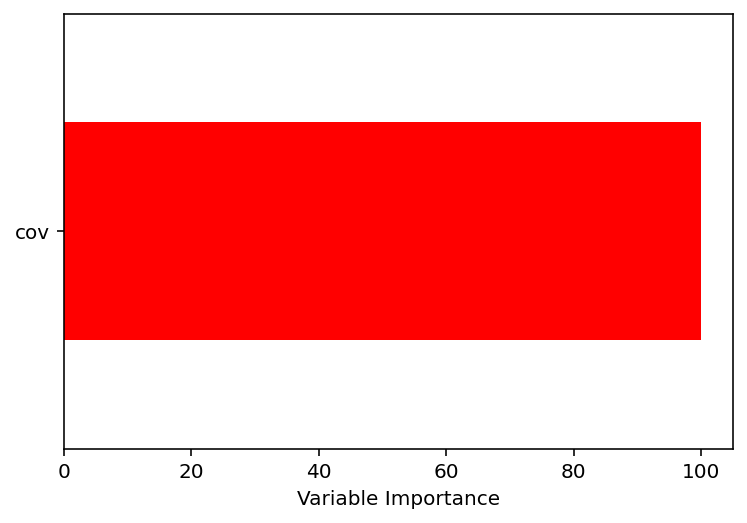

  4%|███▌                                                                               | 1/23 [00:03<01:22,  3.74s/it]

roc_auc_score 0.9622139829175944


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


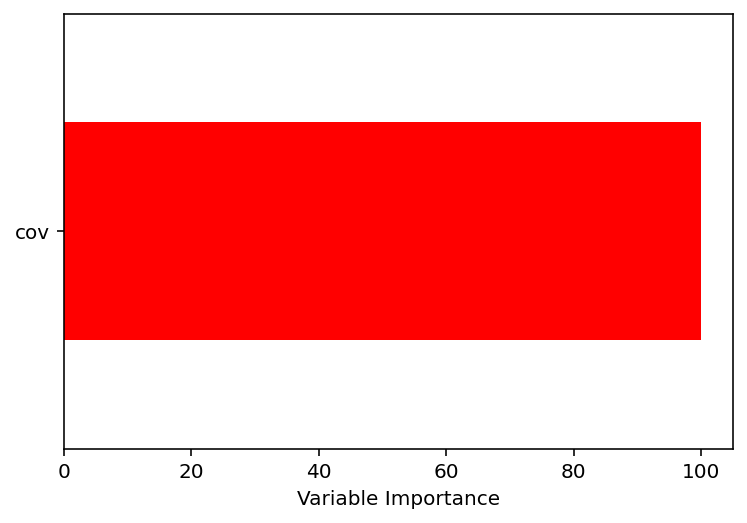

  9%|███████▏                                                                           | 2/23 [00:07<01:17,  3.68s/it]

roc_auc_score 0.9668746504077996


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


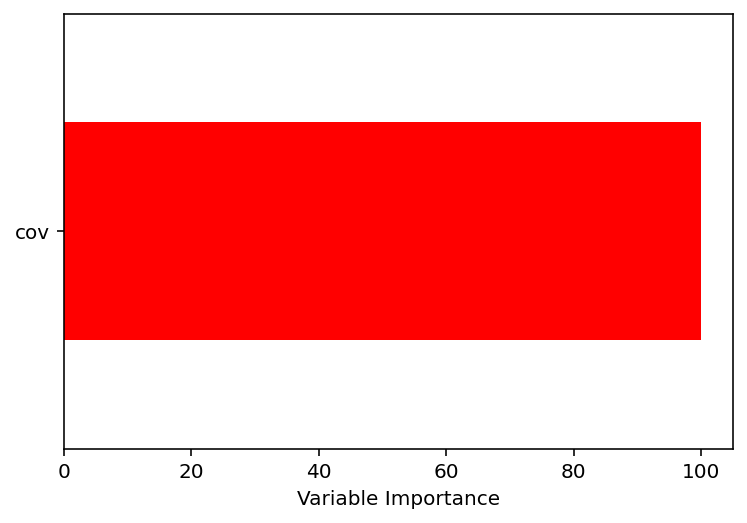

 13%|██████████▊                                                                        | 3/23 [00:11<01:14,  3.71s/it]

roc_auc_score 0.9888928805633963


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


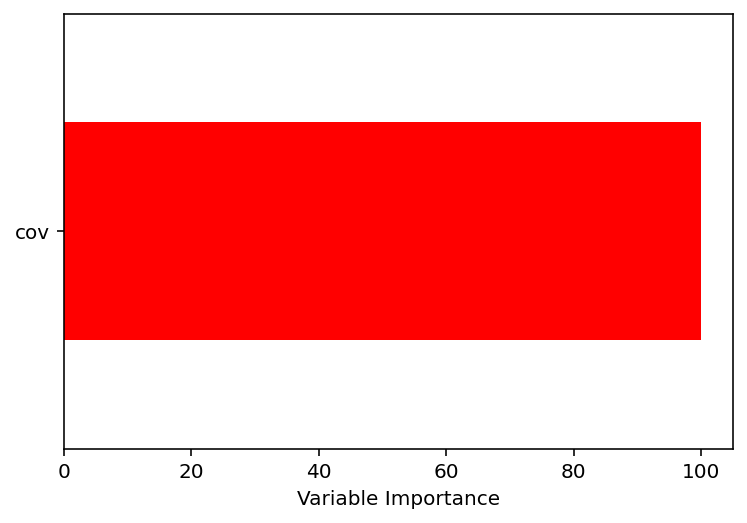

 17%|██████████████▍                                                                    | 4/23 [00:14<01:10,  3.70s/it]

roc_auc_score 0.9512272760217413


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


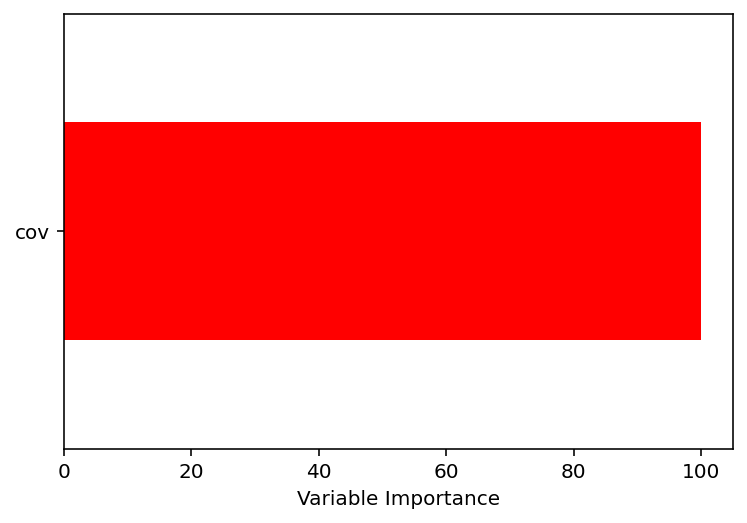

 22%|██████████████████                                                                 | 5/23 [00:18<01:06,  3.71s/it]

roc_auc_score 0.998924546547564


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


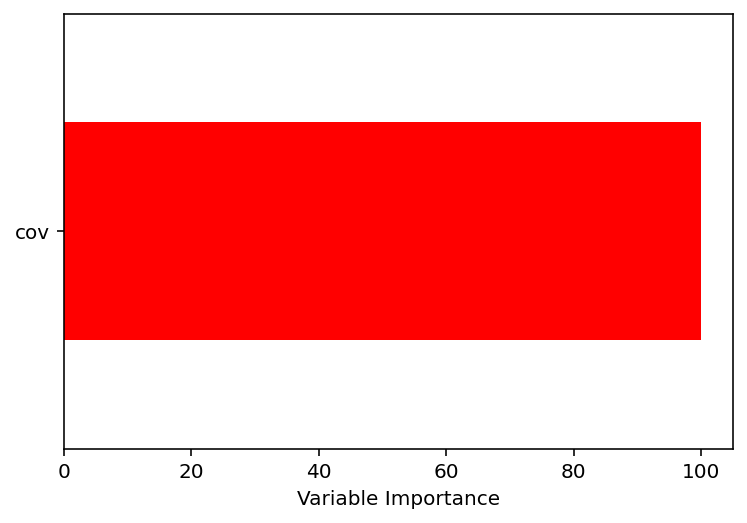

 26%|█████████████████████▋                                                             | 6/23 [00:22<01:03,  3.71s/it]

roc_auc_score 0.9550090573187013


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


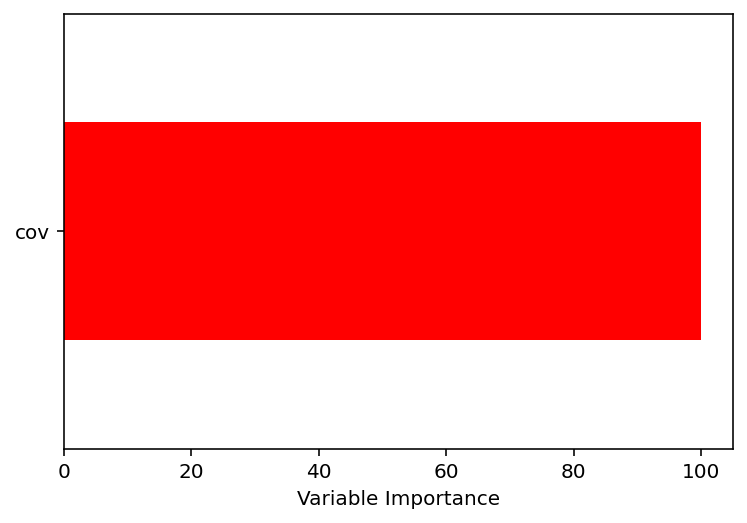

 30%|█████████████████████████▎                                                         | 7/23 [00:25<00:58,  3.67s/it]

roc_auc_score 0.9488492917029238


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


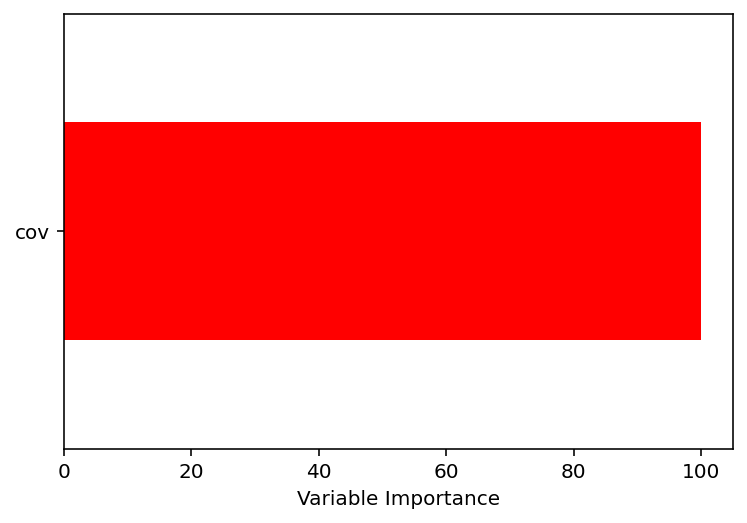

 35%|████████████████████████████▊                                                      | 8/23 [00:29<00:55,  3.69s/it]

roc_auc_score 0.9474381688551058


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


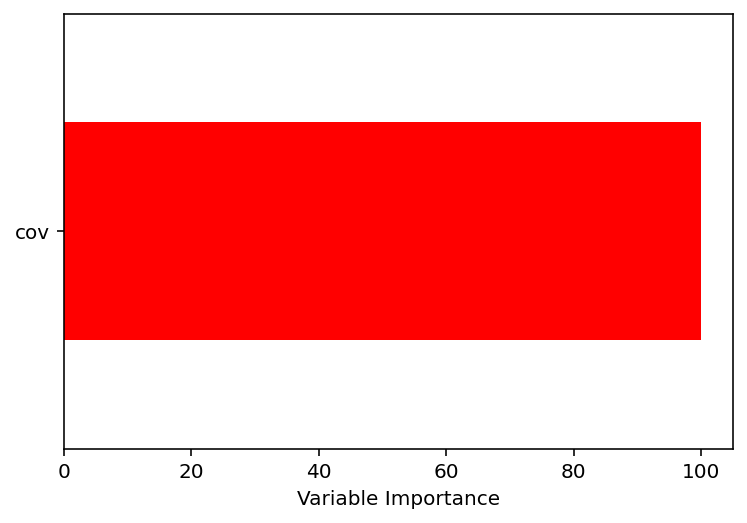

 39%|████████████████████████████████▍                                                  | 9/23 [00:33<00:51,  3.69s/it]

roc_auc_score 0.9447103536894481


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


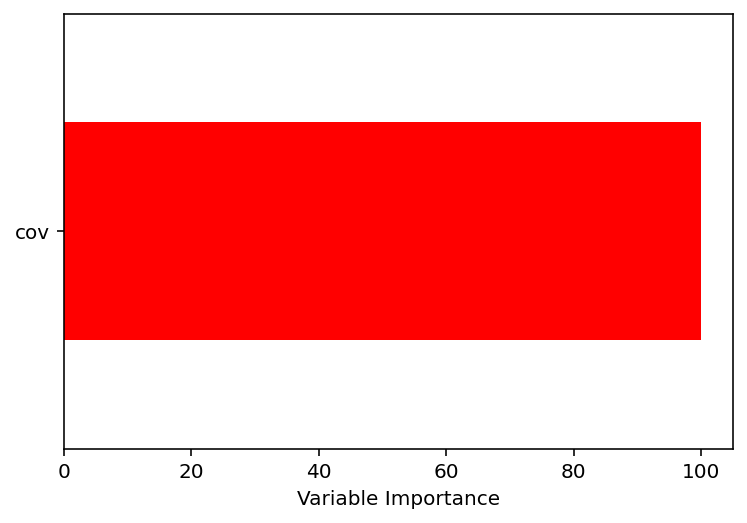

 43%|███████████████████████████████████▋                                              | 10/23 [00:37<00:49,  3.81s/it]

roc_auc_score 0.8686065065906179


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


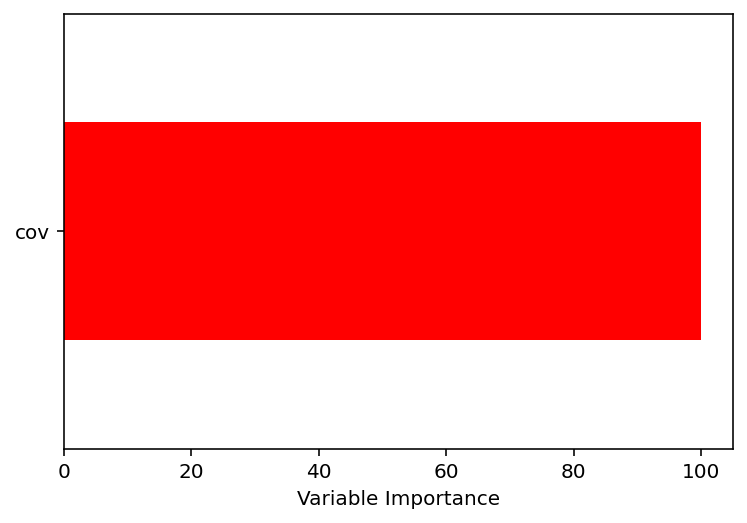

 48%|███████████████████████████████████████▏                                          | 11/23 [00:41<00:46,  3.88s/it]

roc_auc_score 0.8564986839540535


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


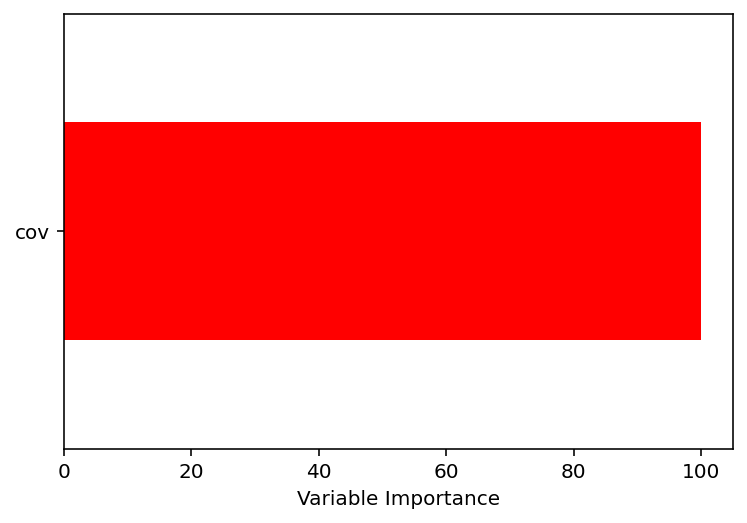

 52%|██████████████████████████████████████████▊                                       | 12/23 [00:45<00:43,  3.96s/it]

roc_auc_score 0.9280730056154527


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


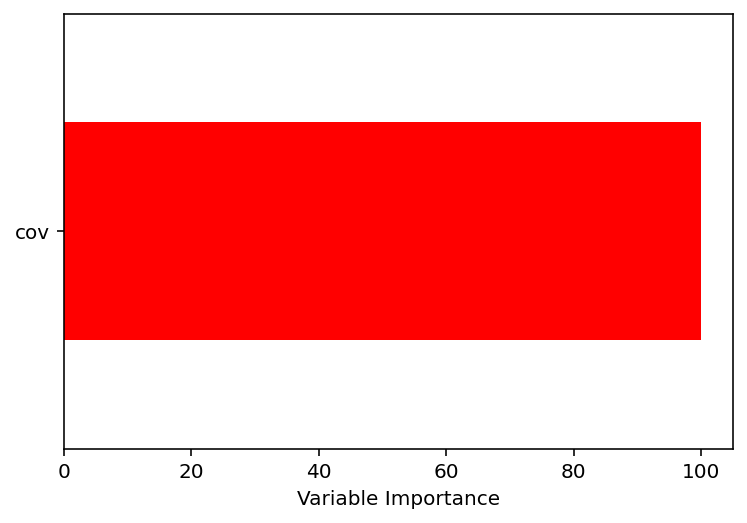

 57%|██████████████████████████████████████████████▎                                   | 13/23 [00:49<00:39,  3.98s/it]

roc_auc_score 0.9628310873991941


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


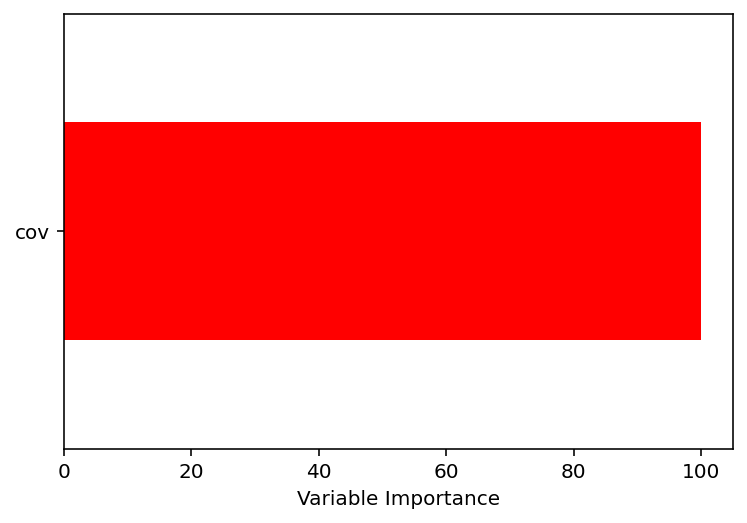

 70%|█████████████████████████████████████████████████████████                         | 16/23 [00:53<00:17,  2.50s/it]

roc_auc_score 0.9565121423450551


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


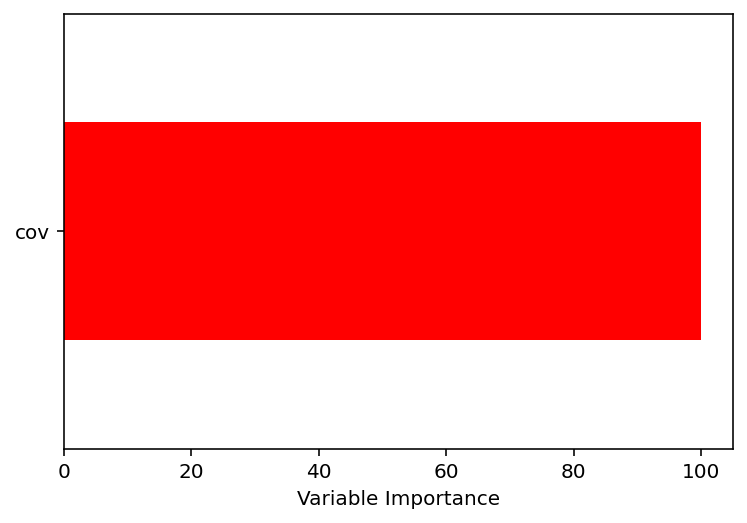

 74%|████████████████████████████████████████████████████████████▌                     | 17/23 [00:57<00:17,  2.84s/it]

roc_auc_score 0.9866251432356135


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


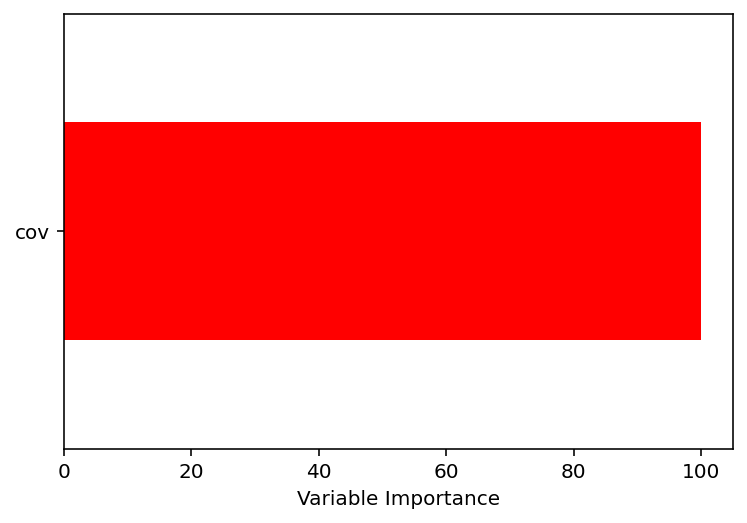

 78%|████████████████████████████████████████████████████████████████▏                 | 18/23 [01:01<00:15,  3.14s/it]

roc_auc_score 0.9980285998316014


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


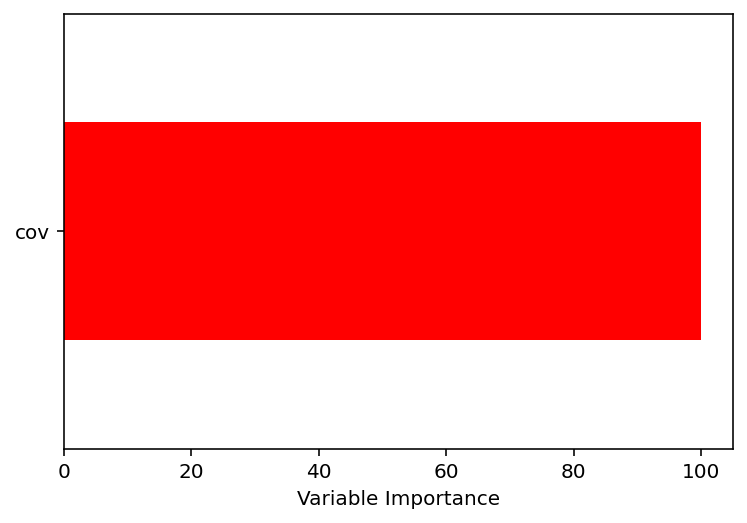

 83%|███████████████████████████████████████████████████████████████████▋              | 19/23 [01:05<00:13,  3.36s/it]

roc_auc_score 0.7930290199841856


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


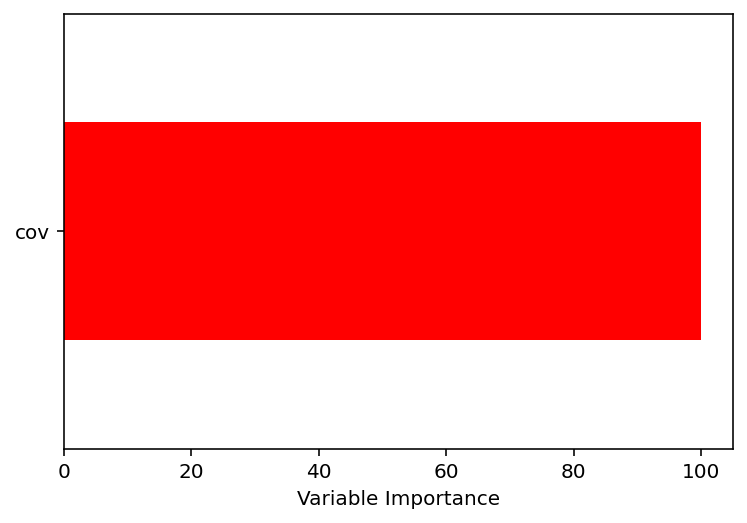

 87%|███████████████████████████████████████████████████████████████████████▎          | 20/23 [01:10<00:10,  3.57s/it]

roc_auc_score 0.9753806959964466


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


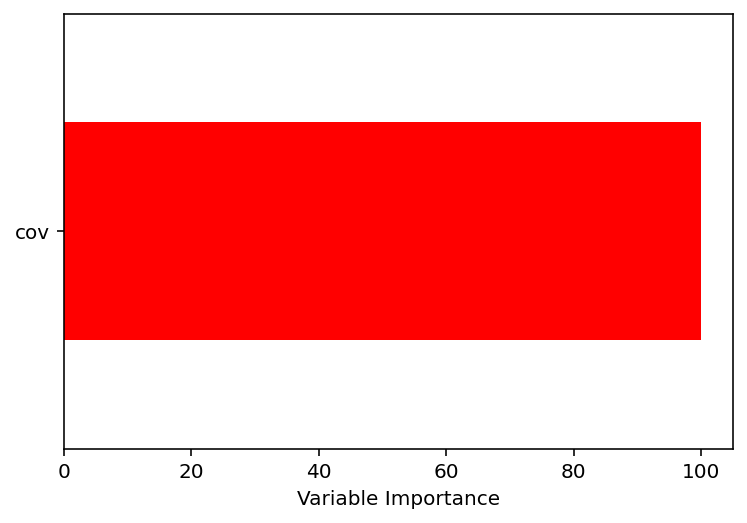

 91%|██████████████████████████████████████████████████████████████████████████▊       | 21/23 [01:14<00:07,  3.72s/it]

roc_auc_score 0.9922472498230879


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


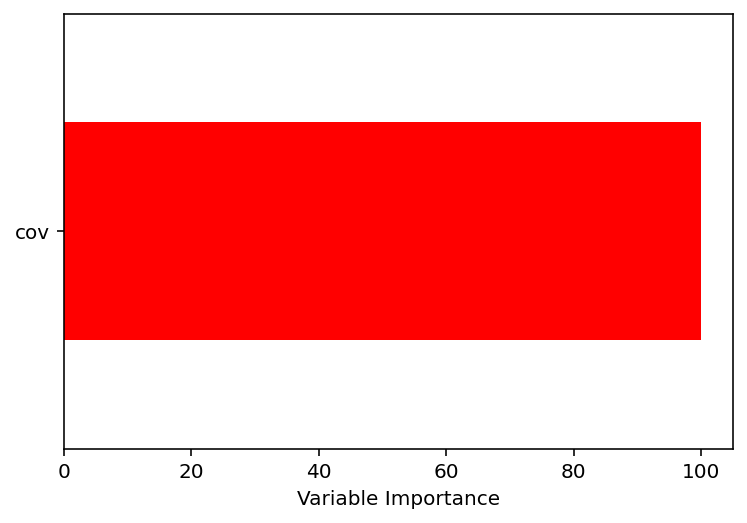

 96%|██████████████████████████████████████████████████████████████████████████████▍   | 22/23 [01:18<00:03,  3.84s/it]

roc_auc_score 0.9698691720336742


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


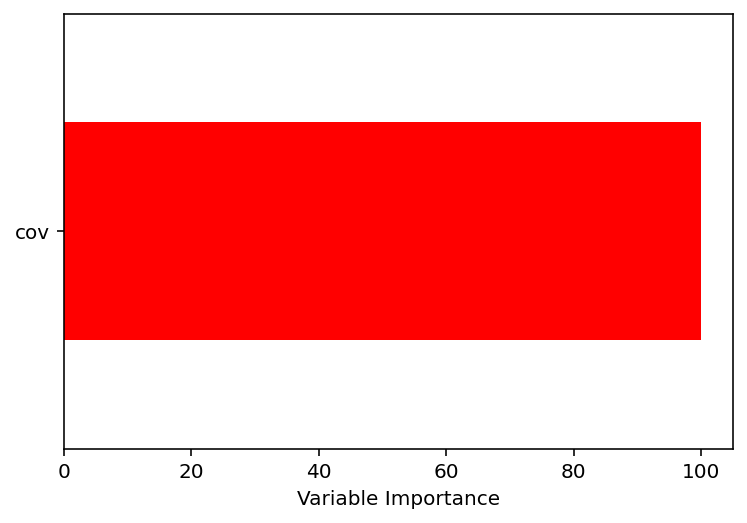

100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [01:22<00:00,  3.58s/it]

roc_auc_score 0.999089263973318
---Run time is 82.34407059999648 seconds ---

Accuracy of each fold: 
 [0.8773752563226247, 0.9200077662362878, 0.9873303167420815, 0.7153284671532847, 0.9907046853410375, 0.9156204379562044, 0.9079802734812822, 0.9636601735144869, 0.931163351416516, 0.72294887039239, 0.9691418602115364, 0.9638845688612407, 0.8201525054466231, 0.9407810499359796, 0.9119351100811124, 0.9937543372657877, 0.5225106469276009, 0.9438424947145877, 0.9913185578592585, 0.9240410752038659, 0.9957601453664445]

Avg accuracy : 
0.90044009287763

Std of accuracy : 
0.1146183079592623
[[87126 15759]
 [ 1765 66356]]
classification report: 
              precision    recall  f1-score   support

           0       0.98      0.85      0.91    102885
           1       0.81      0.97      0.88     68121

    accuracy                           0.90    171006
   macro avg       0.89      0.91      0.90    171006
weighted avg       0.91      0.90      0.90    171006



In [12]:
# XGBoost
print(xgb.__version__)
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc

# Create the Extreme GBM
model = XGBClassifier(n_estimators=100, learning_rate = 0.1,use_label_encoder =False,verbose=None,
                max_depth = 5, eval_metric='logloss')

start_time = timeit.default_timer() #defines start time so computational time can be calculated

acc_score = []
Truth = []
Output = []
 
for train, test in tqdm(splits):
    X_train = X.iloc[train]
    y_train = y.iloc[train]

    X_test = X.iloc[test]
    y_test = y.iloc[test]

    a = y_test.to_numpy() # s.values (pandas<0.24)
    if (a[0] == a).all():
        continue
    
    model.fit(X_train,y_train)

    pred_values = model.predict(X_test)
    pred_prob = model.predict_proba(X_test)[:, 1]
     
    acc = accuracy_score(y_test, pred_values)
    acc_score.append(acc)
    
    Truth.extend(y_test.values.reshape(y_test.shape[0])); ## it is a list
    Output.extend(pred_values); ## it is a list 
    
    #print(model.feature_importances_)
    Importance = pd.DataFrame({'Importance':(model.feature_importances_*100)[0:10]}, 
                          index = (X_train.columns)[0:10])
    Importance.sort_values(by = 'Importance', 
                       axis = 0, 
                       ascending = True).plot(kind = 'barh', 
                                              color = 'r')
    plt.xlabel('Variable Importance')
    plt.gca().legend_ = None
    plt.show()
    #plt.savefig('plot1.png')
    
    ##################################################
    #https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html
    #Compute Area Under the Receiver Operating Characteristic Curve (ROC AUC) from prediction scores.
    print("roc_auc_score", roc_auc_score(y_test, pred_prob))
    
    # calculate the fpr and tpr for all thresholds of the classification
    #fpr, tpr, threshold = metrics.roc_curve(y_test, pred_prob)
    #roc_auc = metrics.auc(fpr, tpr)
    # method I: plt
    #import matplotlib.pyplot as plt
    #plt.title('Receiver Operating Characteristic')
    #plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    #plt.legend(loc = 'lower right')
    #plt.plot([0, 1], [0, 1],'r--')
    #plt.xlim([-0.05, 1])
    #plt.ylim([0, 1.05])
    #plt.ylabel('True Positive Rate')
    #plt.xlabel('False Positive Rate')
    #plt.show()
    ##################################################
    
elapsed = timeit.default_timer() - start_time #gives total computation time
print("---Run time is %s seconds ---" % elapsed) #prints computation time
print()

print('Accuracy of each fold: \n {}'.format(acc_score))
print()
print('Avg accuracy : \n{}'.format(np.mean(acc_score))); 
print()
print('Std of accuracy : \n{}'.format(np.std(acc_score)))

cm = confusion_matrix(Truth, Output)
print(cm)
print("classification report: ")
print(classification_report(Truth, Output))

sensitivity = cm[0][0]/(cm[0][0]+cm[0][1])
specificity = cm[1][1]/(cm[1][0]+cm[1][1])
precision = (cm[0][0])/(cm[0][0]+cm[1][0])
f1_score = (2*precision*sensitivity)/(precision+sensitivity)

performance_dict['Avg Accuracy'].append(np.mean(acc_score))
performance_dict['Std Accuracy'].append(np.std(acc_score))
performance_dict['Sensitivity'].append(sensitivity)
performance_dict['Specificity'].append(specificity)
performance_dict['Precision'].append(precision)
performance_dict['F1 score'].append(f1_score)
performance_dict['Run time'].append(elapsed)

  0%|                                                                                           | 0/23 [00:00<?, ?it/s]

[0]	validation_0-logloss:0.62122	validation_1-logloss:0.62695
[1]	validation_0-logloss:0.56329	validation_1-logloss:0.57282
[2]	validation_0-logloss:0.51586	validation_1-logloss:0.52793
[3]	validation_0-logloss:0.47668	validation_1-logloss:0.49019


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[4]	validation_0-logloss:0.44393	validation_1-logloss:0.45826
[5]	validation_0-logloss:0.41631	validation_1-logloss:0.43105
[6]	validation_0-logloss:0.39289	validation_1-logloss:0.40773
[7]	validation_0-logloss:0.37304	validation_1-logloss:0.38764
[8]	validation_0-logloss:0.35613	validation_1-logloss:0.37029
[9]	validation_0-logloss:0.34165	validation_1-logloss:0.35525
[10]	validation_0-logloss:0.32926	validation_1-logloss:0.34222
[11]	validation_0-logloss:0.31864	validation_1-logloss:0.33084
[12]	validation_0-logloss:0.30953	validation_1-logloss:0.32093
[13]	validation_0-logloss:0.30163	validation_1-logloss:0.31229
[14]	validation_0-logloss:0.29483	validation_1-logloss:0.30473
[15]	validation_0-logloss:0.28897	validation_1-logloss:0.29811
[16]	validation_0-logloss:0.28394	validation_1-logloss:0.29234
[17]	validation_0-logloss:0.27958	validation_1-logloss:0.28726
[18]	validation_0-logloss:0.27584	validation_1-logloss:0.28281
[19]	validation_0-logloss:0.27259	validation_1-logloss:0.2789

  4%|███▌                                                                               | 1/23 [00:04<01:37,  4.42s/it]

[0]	validation_0-logloss:0.61902	validation_1-logloss:0.62739
[1]	validation_0-logloss:0.55863	validation_1-logloss:0.57360
[2]	validation_0-logloss:0.50865	validation_1-logloss:0.52905


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[3]	validation_0-logloss:0.46680	validation_1-logloss:0.49155
[4]	validation_0-logloss:0.43144	validation_1-logloss:0.45981
[5]	validation_0-logloss:0.40133	validation_1-logloss:0.43279
[6]	validation_0-logloss:0.37557	validation_1-logloss:0.40959
[7]	validation_0-logloss:0.35341	validation_1-logloss:0.38962
[8]	validation_0-logloss:0.33431	validation_1-logloss:0.37240
[9]	validation_0-logloss:0.31777	validation_1-logloss:0.35743
[10]	validation_0-logloss:0.30345	validation_1-logloss:0.34443
[11]	validation_0-logloss:0.29106	validation_1-logloss:0.33312
[12]	validation_0-logloss:0.28030	validation_1-logloss:0.32323
[13]	validation_0-logloss:0.27095	validation_1-logloss:0.31463
[14]	validation_0-logloss:0.26282	validation_1-logloss:0.30709
[15]	validation_0-logloss:0.25576	validation_1-logloss:0.30049
[16]	validation_0-logloss:0.24964	validation_1-logloss:0.29470
[17]	validation_0-logloss:0.24430	validation_1-logloss:0.28963
[18]	validation_0-logloss:0.23968	validation_1-logloss:0.28518

  9%|███████▏                                                                           | 2/23 [00:08<01:30,  4.32s/it]

[0]	validation_0-logloss:0.60183	validation_1-logloss:0.62805
[1]	validation_0-logloss:0.52707	validation_1-logloss:0.57477
[2]	validation_0-logloss:0.46475	validation_1-logloss:0.53058


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[3]	validation_0-logloss:0.41208	validation_1-logloss:0.49350
[4]	validation_0-logloss:0.36700	validation_1-logloss:0.46209
[5]	validation_0-logloss:0.32835	validation_1-logloss:0.43538
[6]	validation_0-logloss:0.29478	validation_1-logloss:0.41245
[7]	validation_0-logloss:0.26562	validation_1-logloss:0.39272
[8]	validation_0-logloss:0.23999	validation_1-logloss:0.37571
[9]	validation_0-logloss:0.21752	validation_1-logloss:0.36093
[10]	validation_0-logloss:0.19777	validation_1-logloss:0.34813
[11]	validation_0-logloss:0.18032	validation_1-logloss:0.33698
[12]	validation_0-logloss:0.16488	validation_1-logloss:0.32727
[13]	validation_0-logloss:0.15111	validation_1-logloss:0.31879
[14]	validation_0-logloss:0.13892	validation_1-logloss:0.31138
[15]	validation_0-logloss:0.12803	validation_1-logloss:0.30489
[16]	validation_0-logloss:0.11838	validation_1-logloss:0.29922
[17]	validation_0-logloss:0.10975	validation_1-logloss:0.29425
[18]	validation_0-logloss:0.10200	validation_1-logloss:0.28991

 13%|██████████▊                                                                        | 3/23 [00:12<01:26,  4.33s/it]

[0]	validation_0-logloss:0.65266	validation_1-logloss:0.62561
[1]	validation_0-logloss:0.62113	validation_1-logloss:0.57040
[2]	validation_0-logloss:0.59626	validation_1-logloss:0.52450


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[3]	validation_0-logloss:0.57654	validation_1-logloss:0.48601
[4]	validation_0-logloss:0.56088	validation_1-logloss:0.45339
[5]	validation_0-logloss:0.54844	validation_1-logloss:0.42557
[6]	validation_0-logloss:0.53862	validation_1-logloss:0.40172
[7]	validation_0-logloss:0.53101	validation_1-logloss:0.38119
[8]	validation_0-logloss:0.52516	validation_1-logloss:0.36343
[9]	validation_0-logloss:0.52063	validation_1-logloss:0.34806
[10]	validation_0-logloss:0.51733	validation_1-logloss:0.33466
[11]	validation_0-logloss:0.51499	validation_1-logloss:0.32302
[12]	validation_0-logloss:0.51331	validation_1-logloss:0.31285
[13]	validation_0-logloss:0.51235	validation_1-logloss:0.30398
[14]	validation_0-logloss:0.51187	validation_1-logloss:0.29621
[15]	validation_0-logloss:0.51179	validation_1-logloss:0.28940
[16]	validation_0-logloss:0.51203	validation_1-logloss:0.28344
[17]	validation_0-logloss:0.51253	validation_1-logloss:0.27821
[18]	validation_0-logloss:0.51328	validation_1-logloss:0.27363

 17%|██████████████▍                                                                    | 4/23 [00:17<01:22,  4.32s/it]

[0]	validation_0-logloss:0.61210	validation_1-logloss:0.62815
[1]	validation_0-logloss:0.54478	validation_1-logloss:0.57503
[2]	validation_0-logloss:0.48818	validation_1-logloss:0.53092


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[3]	validation_0-logloss:0.44013	validation_1-logloss:0.49394
[4]	validation_0-logloss:0.39872	validation_1-logloss:0.46261
[5]	validation_0-logloss:0.36291	validation_1-logloss:0.43591
[6]	validation_0-logloss:0.33187	validation_1-logloss:0.41302
[7]	validation_0-logloss:0.30465	validation_1-logloss:0.39330
[8]	validation_0-logloss:0.28081	validation_1-logloss:0.37630
[9]	validation_0-logloss:0.25975	validation_1-logloss:0.36151
[10]	validation_0-logloss:0.24113	validation_1-logloss:0.34870
[11]	validation_0-logloss:0.22464	validation_1-logloss:0.33754
[12]	validation_0-logloss:0.20998	validation_1-logloss:0.32779
[13]	validation_0-logloss:0.19697	validation_1-logloss:0.31932
[14]	validation_0-logloss:0.18535	validation_1-logloss:0.31188
[15]	validation_0-logloss:0.17497	validation_1-logloss:0.30536
[16]	validation_0-logloss:0.16567	validation_1-logloss:0.29966
[17]	validation_0-logloss:0.15739	validation_1-logloss:0.29466
[18]	validation_0-logloss:0.14995	validation_1-logloss:0.29025

 22%|██████████████████                                                                 | 5/23 [00:21<01:17,  4.31s/it]

[0]	validation_0-logloss:0.61596	validation_1-logloss:0.62738
[1]	validation_0-logloss:0.55340	validation_1-logloss:0.57358
[2]	validation_0-logloss:0.50182	validation_1-logloss:0.52898


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[3]	validation_0-logloss:0.45882	validation_1-logloss:0.49148
[4]	validation_0-logloss:0.42260	validation_1-logloss:0.45978
[5]	validation_0-logloss:0.39187	validation_1-logloss:0.43275
[6]	validation_0-logloss:0.36565	validation_1-logloss:0.40960
[7]	validation_0-logloss:0.34317	validation_1-logloss:0.38964
[8]	validation_0-logloss:0.32386	validation_1-logloss:0.37240
[9]	validation_0-logloss:0.30721	validation_1-logloss:0.35746
[10]	validation_0-logloss:0.29284	validation_1-logloss:0.34447
[11]	validation_0-logloss:0.28038	validation_1-logloss:0.33320
[12]	validation_0-logloss:0.26958	validation_1-logloss:0.32336
[13]	validation_0-logloss:0.26019	validation_1-logloss:0.31477
[14]	validation_0-logloss:0.25205	validation_1-logloss:0.30728
[15]	validation_0-logloss:0.24496	validation_1-logloss:0.30073
[16]	validation_0-logloss:0.23877	validation_1-logloss:0.29497
[17]	validation_0-logloss:0.23338	validation_1-logloss:0.28995
[18]	validation_0-logloss:0.22869	validation_1-logloss:0.28555

 26%|█████████████████████▋                                                             | 6/23 [00:25<01:12,  4.29s/it]

[0]	validation_0-logloss:0.63014	validation_1-logloss:0.62700
[1]	validation_0-logloss:0.57859	validation_1-logloss:0.57281
[2]	validation_0-logloss:0.53595	validation_1-logloss:0.52792


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[3]	validation_0-logloss:0.50041	validation_1-logloss:0.49018
[4]	validation_0-logloss:0.47057	validation_1-logloss:0.45819
[5]	validation_0-logloss:0.44548	validation_1-logloss:0.43087
[6]	validation_0-logloss:0.42415	validation_1-logloss:0.40749
[7]	validation_0-logloss:0.40610	validation_1-logloss:0.38733
[8]	validation_0-logloss:0.39078	validation_1-logloss:0.36986
[9]	validation_0-logloss:0.37782	validation_1-logloss:0.35474
[10]	validation_0-logloss:0.36680	validation_1-logloss:0.34153
[11]	validation_0-logloss:0.35752	validation_1-logloss:0.33002
[12]	validation_0-logloss:0.34971	validation_1-logloss:0.31998
[13]	validation_0-logloss:0.34321	validation_1-logloss:0.31117
[14]	validation_0-logloss:0.33785	validation_1-logloss:0.30348
[15]	validation_0-logloss:0.33342	validation_1-logloss:0.29670
[16]	validation_0-logloss:0.32983	validation_1-logloss:0.29075
[17]	validation_0-logloss:0.32699	validation_1-logloss:0.28554
[18]	validation_0-logloss:0.32481	validation_1-logloss:0.28093

 30%|█████████████████████████▎                                                         | 7/23 [00:30<01:08,  4.26s/it]

[0]	validation_0-logloss:0.60730	validation_1-logloss:0.62772
[1]	validation_0-logloss:0.53707	validation_1-logloss:0.57425
[2]	validation_0-logloss:0.47870	validation_1-logloss:0.52985


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[3]	validation_0-logloss:0.42938	validation_1-logloss:0.49259
[4]	validation_0-logloss:0.38748	validation_1-logloss:0.46103
[5]	validation_0-logloss:0.35170	validation_1-logloss:0.43417
[6]	validation_0-logloss:0.32079	validation_1-logloss:0.41112
[7]	validation_0-logloss:0.29376	validation_1-logloss:0.39131
[8]	validation_0-logloss:0.27032	validation_1-logloss:0.37418
[9]	validation_0-logloss:0.24978	validation_1-logloss:0.35934
[10]	validation_0-logloss:0.23168	validation_1-logloss:0.34647
[11]	validation_0-logloss:0.21573	validation_1-logloss:0.33526
[12]	validation_0-logloss:0.20172	validation_1-logloss:0.32550
[13]	validation_0-logloss:0.18922	validation_1-logloss:0.31698
[14]	validation_0-logloss:0.17823	validation_1-logloss:0.30953
[15]	validation_0-logloss:0.16838	validation_1-logloss:0.30300
[16]	validation_0-logloss:0.15966	validation_1-logloss:0.29730
[17]	validation_0-logloss:0.15182	validation_1-logloss:0.29231
[18]	validation_0-logloss:0.14493	validation_1-logloss:0.28792

 35%|████████████████████████████▊                                                      | 8/23 [00:34<01:04,  4.31s/it]

[0]	validation_0-logloss:0.62987	validation_1-logloss:0.62735
[1]	validation_0-logloss:0.57739	validation_1-logloss:0.57348
[2]	validation_0-logloss:0.53354	validation_1-logloss:0.52877


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[3]	validation_0-logloss:0.49636	validation_1-logloss:0.49127
[4]	validation_0-logloss:0.46450	validation_1-logloss:0.45949
[5]	validation_0-logloss:0.43719	validation_1-logloss:0.43234
[6]	validation_0-logloss:0.41369	validation_1-logloss:0.40911
[7]	validation_0-logloss:0.39319	validation_1-logloss:0.38912
[8]	validation_0-logloss:0.37534	validation_1-logloss:0.37178
[9]	validation_0-logloss:0.35979	validation_1-logloss:0.35680
[10]	validation_0-logloss:0.34628	validation_1-logloss:0.34376
[11]	validation_0-logloss:0.33437	validation_1-logloss:0.33235
[12]	validation_0-logloss:0.32394	validation_1-logloss:0.32244
[13]	validation_0-logloss:0.31472	validation_1-logloss:0.31379
[14]	validation_0-logloss:0.30663	validation_1-logloss:0.30620
[15]	validation_0-logloss:0.29944	validation_1-logloss:0.29953
[16]	validation_0-logloss:0.29308	validation_1-logloss:0.29372
[17]	validation_0-logloss:0.28747	validation_1-logloss:0.28858
[18]	validation_0-logloss:0.28244	validation_1-logloss:0.28410

 39%|████████████████████████████████▍                                                  | 9/23 [00:38<01:00,  4.32s/it]

[0]	validation_0-logloss:0.64730	validation_1-logloss:0.62543
[1]	validation_0-logloss:0.61198	validation_1-logloss:0.56998


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[2]	validation_0-logloss:0.58452	validation_1-logloss:0.52396
[3]	validation_0-logloss:0.56306	validation_1-logloss:0.48534
[4]	validation_0-logloss:0.54630	validation_1-logloss:0.45262
[5]	validation_0-logloss:0.53328	validation_1-logloss:0.42469
[6]	validation_0-logloss:0.52325	validation_1-logloss:0.40077
[7]	validation_0-logloss:0.51562	validation_1-logloss:0.38015
[8]	validation_0-logloss:0.51000	validation_1-logloss:0.36231
[9]	validation_0-logloss:0.50602	validation_1-logloss:0.34688
[10]	validation_0-logloss:0.50337	validation_1-logloss:0.33342
[11]	validation_0-logloss:0.50186	validation_1-logloss:0.32173
[12]	validation_0-logloss:0.50121	validation_1-logloss:0.31151
[13]	validation_0-logloss:0.50131	validation_1-logloss:0.30260
[14]	validation_0-logloss:0.50196	validation_1-logloss:0.29479
[15]	validation_0-logloss:0.50300	validation_1-logloss:0.28796
[16]	validation_0-logloss:0.50441	validation_1-logloss:0.28199
[17]	validation_0-logloss:0.50609	validation_1-logloss:0.27675


 43%|███████████████████████████████████▋                                              | 10/23 [00:43<00:56,  4.34s/it]

[0]	validation_0-logloss:0.62091	validation_1-logloss:0.62800
[1]	validation_0-logloss:0.56095	validation_1-logloss:0.57473
[2]	validation_0-logloss:0.51011	validation_1-logloss:0.53051


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[3]	validation_0-logloss:0.46689	validation_1-logloss:0.49340
[4]	validation_0-logloss:0.43007	validation_1-logloss:0.46199
[5]	validation_0-logloss:0.39789	validation_1-logloss:0.43520
[6]	validation_0-logloss:0.37004	validation_1-logloss:0.41225
[7]	validation_0-logloss:0.34569	validation_1-logloss:0.39243
[8]	validation_0-logloss:0.32437	validation_1-logloss:0.37535
[9]	validation_0-logloss:0.30562	validation_1-logloss:0.36050
[10]	validation_0-logloss:0.28910	validation_1-logloss:0.34762
[11]	validation_0-logloss:0.27454	validation_1-logloss:0.33638
[12]	validation_0-logloss:0.26165	validation_1-logloss:0.32660
[13]	validation_0-logloss:0.25013	validation_1-logloss:0.31804
[14]	validation_0-logloss:0.23994	validation_1-logloss:0.31054
[15]	validation_0-logloss:0.23090	validation_1-logloss:0.30395
[16]	validation_0-logloss:0.22284	validation_1-logloss:0.29818
[17]	validation_0-logloss:0.21568	validation_1-logloss:0.29311
[18]	validation_0-logloss:0.20925	validation_1-logloss:0.28868

 48%|███████████████████████████████████████▏                                          | 11/23 [00:47<00:51,  4.32s/it]

[0]	validation_0-logloss:0.60883	validation_1-logloss:0.62775
[1]	validation_0-logloss:0.53966	validation_1-logloss:0.57422
[2]	validation_0-logloss:0.48205	validation_1-logloss:0.52976


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[3]	validation_0-logloss:0.43340	validation_1-logloss:0.49256
[4]	validation_0-logloss:0.39174	validation_1-logloss:0.46099
[5]	validation_0-logloss:0.35608	validation_1-logloss:0.43410
[6]	validation_0-logloss:0.32521	validation_1-logloss:0.41106
[7]	validation_0-logloss:0.29819	validation_1-logloss:0.39121
[8]	validation_0-logloss:0.27468	validation_1-logloss:0.37409
[9]	validation_0-logloss:0.25406	validation_1-logloss:0.35924
[10]	validation_0-logloss:0.23595	validation_1-logloss:0.34636
[11]	validation_0-logloss:0.21983	validation_1-logloss:0.33516
[12]	validation_0-logloss:0.20556	validation_1-logloss:0.32537
[13]	validation_0-logloss:0.19291	validation_1-logloss:0.31681
[14]	validation_0-logloss:0.18178	validation_1-logloss:0.30936
[15]	validation_0-logloss:0.17176	validation_1-logloss:0.30283
[16]	validation_0-logloss:0.16296	validation_1-logloss:0.29712
[17]	validation_0-logloss:0.15501	validation_1-logloss:0.29210
[18]	validation_0-logloss:0.14799	validation_1-logloss:0.28773

 52%|██████████████████████████████████████████▊                                       | 12/23 [00:51<00:47,  4.33s/it]

[0]	validation_0-logloss:0.64333	validation_1-logloss:0.62652
[1]	validation_0-logloss:0.60229	validation_1-logloss:0.57204
[2]	validation_0-logloss:0.56820	validation_1-logloss:0.52674


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[3]	validation_0-logloss:0.53951	validation_1-logloss:0.48879
[4]	validation_0-logloss:0.51521	validation_1-logloss:0.45663
[5]	validation_0-logloss:0.49445	validation_1-logloss:0.42921
[6]	validation_0-logloss:0.47673	validation_1-logloss:0.40570
[7]	validation_0-logloss:0.46136	validation_1-logloss:0.38544
[8]	validation_0-logloss:0.44814	validation_1-logloss:0.36795
[9]	validation_0-logloss:0.43667	validation_1-logloss:0.35275
[10]	validation_0-logloss:0.42685	validation_1-logloss:0.33957
[11]	validation_0-logloss:0.41823	validation_1-logloss:0.32807
[12]	validation_0-logloss:0.41066	validation_1-logloss:0.31802
[13]	validation_0-logloss:0.40402	validation_1-logloss:0.30927
[14]	validation_0-logloss:0.39835	validation_1-logloss:0.30161
[15]	validation_0-logloss:0.39320	validation_1-logloss:0.29486
[16]	validation_0-logloss:0.38881	validation_1-logloss:0.28898
[17]	validation_0-logloss:0.38486	validation_1-logloss:0.28381
[18]	validation_0-logloss:0.38143	validation_1-logloss:0.27926

 57%|██████████████████████████████████████████████▎                                   | 13/23 [00:56<00:43,  4.33s/it]

[0]	validation_0-logloss:0.62102	validation_1-logloss:0.62785
[1]	validation_0-logloss:0.56098	validation_1-logloss:0.57443
[2]	validation_0-logloss:0.51028	validation_1-logloss:0.53005


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[3]	validation_0-logloss:0.46720	validation_1-logloss:0.49289
[4]	validation_0-logloss:0.42993	validation_1-logloss:0.46133
[5]	validation_0-logloss:0.39755	validation_1-logloss:0.43448
[6]	validation_0-logloss:0.36933	validation_1-logloss:0.41142
[7]	validation_0-logloss:0.34466	validation_1-logloss:0.39159
[8]	validation_0-logloss:0.32306	validation_1-logloss:0.37444
[9]	validation_0-logloss:0.30398	validation_1-logloss:0.35958
[10]	validation_0-logloss:0.28712	validation_1-logloss:0.34664
[11]	validation_0-logloss:0.27226	validation_1-logloss:0.33538
[12]	validation_0-logloss:0.25909	validation_1-logloss:0.32557
[13]	validation_0-logloss:0.24724	validation_1-logloss:0.31700
[14]	validation_0-logloss:0.23683	validation_1-logloss:0.30949
[15]	validation_0-logloss:0.22746	validation_1-logloss:0.30290
[16]	validation_0-logloss:0.21896	validation_1-logloss:0.29714
[17]	validation_0-logloss:0.21151	validation_1-logloss:0.29207
[18]	validation_0-logloss:0.20474	validation_1-logloss:0.28762

 61%|█████████████████████████████████████████████████▉                                | 14/23 [01:00<00:38,  4.33s/it]

[0]	validation_0-logloss:0.71851	validation_1-logloss:0.62267
[1]	validation_0-logloss:0.74376	validation_1-logloss:0.56503
[2]	validation_0-logloss:0.76848	validation_1-logloss:0.51712


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[3]	validation_0-logloss:0.79260	validation_1-logloss:0.47698
[4]	validation_0-logloss:0.81609	validation_1-logloss:0.44292
[5]	validation_0-logloss:0.83898	validation_1-logloss:0.41389
[6]	validation_0-logloss:0.86084	validation_1-logloss:0.38903
[7]	validation_0-logloss:0.88225	validation_1-logloss:0.36758
[8]	validation_0-logloss:0.90237	validation_1-logloss:0.34902
[9]	validation_0-logloss:0.92175	validation_1-logloss:0.33296
[10]	validation_0-logloss:0.94015	validation_1-logloss:0.31899
[11]	validation_0-logloss:0.95745	validation_1-logloss:0.30684
[12]	validation_0-logloss:0.97393	validation_1-logloss:0.29624
[13]	validation_0-logloss:0.98940	validation_1-logloss:0.28696
[14]	validation_0-logloss:1.00391	validation_1-logloss:0.27885
[15]	validation_0-logloss:1.01758	validation_1-logloss:0.27177
[16]	validation_0-logloss:1.03027	validation_1-logloss:0.26555
[17]	validation_0-logloss:1.04221	validation_1-logloss:0.26009
[18]	validation_0-logloss:1.05326	validation_1-logloss:0.25530

 65%|█████████████████████████████████████████████████████▍                            | 15/23 [01:04<00:34,  4.32s/it]

[0]	validation_0-logloss:0.62810	validation_1-logloss:0.62751
[1]	validation_0-logloss:0.57408	validation_1-logloss:0.57384
[2]	validation_0-logloss:0.52889	validation_1-logloss:0.52928


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[3]	validation_0-logloss:0.49034	validation_1-logloss:0.49188
[4]	validation_0-logloss:0.45740	validation_1-logloss:0.46016
[5]	validation_0-logloss:0.42892	validation_1-logloss:0.43316
[6]	validation_0-logloss:0.40428	validation_1-logloss:0.41001
[7]	validation_0-logloss:0.38287	validation_1-logloss:0.39006
[8]	validation_0-logloss:0.36414	validation_1-logloss:0.37279
[9]	validation_0-logloss:0.34766	validation_1-logloss:0.35787
[10]	validation_0-logloss:0.33280	validation_1-logloss:0.34487
[11]	validation_0-logloss:0.31975	validation_1-logloss:0.33354
[12]	validation_0-logloss:0.30847	validation_1-logloss:0.32366
[13]	validation_0-logloss:0.29857	validation_1-logloss:0.31503
[14]	validation_0-logloss:0.28945	validation_1-logloss:0.30748
[15]	validation_0-logloss:0.28144	validation_1-logloss:0.30085
[16]	validation_0-logloss:0.27453	validation_1-logloss:0.29506
[17]	validation_0-logloss:0.26809	validation_1-logloss:0.28996
[18]	validation_0-logloss:0.26254	validation_1-logloss:0.28550

 70%|█████████████████████████████████████████████████████████                         | 16/23 [01:09<00:30,  4.30s/it]

[0]	validation_0-logloss:0.61729	validation_1-logloss:0.62741
[1]	validation_0-logloss:0.55539	validation_1-logloss:0.57356
[2]	validation_0-logloss:0.50409	validation_1-logloss:0.52888


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[3]	validation_0-logloss:0.46101	validation_1-logloss:0.49144
[4]	validation_0-logloss:0.42453	validation_1-logloss:0.45972
[5]	validation_0-logloss:0.39333	validation_1-logloss:0.43265
[6]	validation_0-logloss:0.36652	validation_1-logloss:0.40946
[7]	validation_0-logloss:0.34337	validation_1-logloss:0.38951
[8]	validation_0-logloss:0.32328	validation_1-logloss:0.37229
[9]	validation_0-logloss:0.30580	validation_1-logloss:0.35735
[10]	validation_0-logloss:0.29053	validation_1-logloss:0.34438
[11]	validation_0-logloss:0.27718	validation_1-logloss:0.33308
[12]	validation_0-logloss:0.26545	validation_1-logloss:0.32325
[13]	validation_0-logloss:0.25521	validation_1-logloss:0.31466
[14]	validation_0-logloss:0.24611	validation_1-logloss:0.30715
[15]	validation_0-logloss:0.23809	validation_1-logloss:0.30056
[16]	validation_0-logloss:0.23101	validation_1-logloss:0.29480
[17]	validation_0-logloss:0.22474	validation_1-logloss:0.28976
[18]	validation_0-logloss:0.21921	validation_1-logloss:0.28533

 74%|████████████████████████████████████████████████████████████▌                     | 17/23 [01:13<00:25,  4.32s/it]

[0]	validation_0-logloss:0.61732	validation_1-logloss:0.62800
[1]	validation_0-logloss:0.55400	validation_1-logloss:0.57470
[2]	validation_0-logloss:0.50070	validation_1-logloss:0.53043


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[3]	validation_0-logloss:0.45524	validation_1-logloss:0.49332
[4]	validation_0-logloss:0.41605	validation_1-logloss:0.46186
[5]	validation_0-logloss:0.38213	validation_1-logloss:0.43507
[6]	validation_0-logloss:0.35250	validation_1-logloss:0.41208
[7]	validation_0-logloss:0.32672	validation_1-logloss:0.39229
[8]	validation_0-logloss:0.30394	validation_1-logloss:0.37519
[9]	validation_0-logloss:0.28396	validation_1-logloss:0.36036
[10]	validation_0-logloss:0.26632	validation_1-logloss:0.34747
[11]	validation_0-logloss:0.25069	validation_1-logloss:0.33623
[12]	validation_0-logloss:0.23676	validation_1-logloss:0.32642
[13]	validation_0-logloss:0.22444	validation_1-logloss:0.31788
[14]	validation_0-logloss:0.21342	validation_1-logloss:0.31040
[15]	validation_0-logloss:0.20357	validation_1-logloss:0.30383
[16]	validation_0-logloss:0.19479	validation_1-logloss:0.29808
[17]	validation_0-logloss:0.18693	validation_1-logloss:0.29304
[18]	validation_0-logloss:0.17993	validation_1-logloss:0.28860

 78%|████████████████████████████████████████████████████████████████▏                 | 18/23 [01:17<00:21,  4.31s/it]

[0]	validation_0-logloss:0.68419	validation_1-logloss:0.62220
[1]	validation_0-logloss:0.68079	validation_1-logloss:0.56408
[2]	validation_0-logloss:0.68144	validation_1-logloss:0.51580


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[3]	validation_0-logloss:0.68510	validation_1-logloss:0.47530
[4]	validation_0-logloss:0.69101	validation_1-logloss:0.44093
[5]	validation_0-logloss:0.69849	validation_1-logloss:0.41161
[6]	validation_0-logloss:0.70725	validation_1-logloss:0.38646
[7]	validation_0-logloss:0.71688	validation_1-logloss:0.36473
[8]	validation_0-logloss:0.72720	validation_1-logloss:0.34595
[9]	validation_0-logloss:0.73783	validation_1-logloss:0.32963
[10]	validation_0-logloss:0.74880	validation_1-logloss:0.31544
[11]	validation_0-logloss:0.75984	validation_1-logloss:0.30307
[12]	validation_0-logloss:0.77079	validation_1-logloss:0.29228
[13]	validation_0-logloss:0.78168	validation_1-logloss:0.28281
[14]	validation_0-logloss:0.79237	validation_1-logloss:0.27454
[15]	validation_0-logloss:0.80274	validation_1-logloss:0.26727
[16]	validation_0-logloss:0.81283	validation_1-logloss:0.26089
[17]	validation_0-logloss:0.82259	validation_1-logloss:0.25532
[18]	validation_0-logloss:0.83199	validation_1-logloss:0.25042

 83%|███████████████████████████████████████████████████████████████████▋              | 19/23 [01:21<00:17,  4.29s/it]

[0]	validation_0-logloss:0.61771	validation_1-logloss:0.62750
[1]	validation_0-logloss:0.55595	validation_1-logloss:0.57384
[2]	validation_0-logloss:0.50454	validation_1-logloss:0.52926


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[3]	validation_0-logloss:0.46124	validation_1-logloss:0.49189
[4]	validation_0-logloss:0.42435	validation_1-logloss:0.46020
[5]	validation_0-logloss:0.39274	validation_1-logloss:0.43323
[6]	validation_0-logloss:0.36550	validation_1-logloss:0.41012
[7]	validation_0-logloss:0.34189	validation_1-logloss:0.39018
[8]	validation_0-logloss:0.32129	validation_1-logloss:0.37295
[9]	validation_0-logloss:0.30332	validation_1-logloss:0.35804
[10]	validation_0-logloss:0.28757	validation_1-logloss:0.34511
[11]	validation_0-logloss:0.27377	validation_1-logloss:0.33384
[12]	validation_0-logloss:0.26160	validation_1-logloss:0.32400
[13]	validation_0-logloss:0.25090	validation_1-logloss:0.31543
[14]	validation_0-logloss:0.24148	validation_1-logloss:0.30793
[15]	validation_0-logloss:0.23310	validation_1-logloss:0.30135
[16]	validation_0-logloss:0.22569	validation_1-logloss:0.29561
[17]	validation_0-logloss:0.21913	validation_1-logloss:0.29057
[18]	validation_0-logloss:0.21331	validation_1-logloss:0.28614

 87%|███████████████████████████████████████████████████████████████████████▎          | 20/23 [01:26<00:12,  4.30s/it]

[0]	validation_0-logloss:0.61868	validation_1-logloss:0.62831
[1]	validation_0-logloss:0.55674	validation_1-logloss:0.57525
[2]	validation_0-logloss:0.50470	validation_1-logloss:0.53115
[3]	validation_0-logloss:0.46053	validation_1-logloss:0.49424


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[4]	validation_0-logloss:0.42247	validation_1-logloss:0.46290
[5]	validation_0-logloss:0.38942	validation_1-logloss:0.43619
[6]	validation_0-logloss:0.36070	validation_1-logloss:0.41332
[7]	validation_0-logloss:0.33563	validation_1-logloss:0.39359
[8]	validation_0-logloss:0.31360	validation_1-logloss:0.37656
[9]	validation_0-logloss:0.29419	validation_1-logloss:0.36180
[10]	validation_0-logloss:0.27720	validation_1-logloss:0.34896
[11]	validation_0-logloss:0.26214	validation_1-logloss:0.33777
[12]	validation_0-logloss:0.24864	validation_1-logloss:0.32803
[13]	validation_0-logloss:0.23674	validation_1-logloss:0.31952
[14]	validation_0-logloss:0.22619	validation_1-logloss:0.31205
[15]	validation_0-logloss:0.21674	validation_1-logloss:0.30550
[16]	validation_0-logloss:0.20831	validation_1-logloss:0.29977
[17]	validation_0-logloss:0.20082	validation_1-logloss:0.29473
[18]	validation_0-logloss:0.19408	validation_1-logloss:0.29031
[19]	validation_0-logloss:0.18805	validation_1-logloss:0.2864

C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\pandas\plotting\_matplotlib\core.py:386: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)
 91%|██████████████████████████████████████████████████████████████████████████▊       | 21/23 [01:30<00:08,  4.28s/it]

[0]	validation_0-logloss:0.61479	validation_1-logloss:0.62743
[1]	validation_0-logloss:0.55128	validation_1-logloss:0.57367
[2]	validation_0-logloss:0.49884	validation_1-logloss:0.52908


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[3]	validation_0-logloss:0.45484	validation_1-logloss:0.49164
[4]	validation_0-logloss:0.41744	validation_1-logloss:0.45994
[5]	validation_0-logloss:0.38542	validation_1-logloss:0.43290
[6]	validation_0-logloss:0.35795	validation_1-logloss:0.40975
[7]	validation_0-logloss:0.33435	validation_1-logloss:0.38980
[8]	validation_0-logloss:0.31392	validation_1-logloss:0.37260
[9]	validation_0-logloss:0.29615	validation_1-logloss:0.35769
[10]	validation_0-logloss:0.28063	validation_1-logloss:0.34474
[11]	validation_0-logloss:0.26707	validation_1-logloss:0.33349
[12]	validation_0-logloss:0.25521	validation_1-logloss:0.32366
[13]	validation_0-logloss:0.24471	validation_1-logloss:0.31508
[14]	validation_0-logloss:0.23565	validation_1-logloss:0.30759
[15]	validation_0-logloss:0.22744	validation_1-logloss:0.30105
[16]	validation_0-logloss:0.22031	validation_1-logloss:0.29530
[17]	validation_0-logloss:0.21393	validation_1-logloss:0.29026
[18]	validation_0-logloss:0.20837	validation_1-logloss:0.28586

 96%|██████████████████████████████████████████████████████████████████████████████▍   | 22/23 [01:34<00:04,  4.31s/it]

[0]	validation_0-logloss:0.61553	validation_1-logloss:0.62840
[1]	validation_0-logloss:0.55105	validation_1-logloss:0.57541
[2]	validation_0-logloss:0.49677	validation_1-logloss:0.53148


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[3]	validation_0-logloss:0.45041	validation_1-logloss:0.49460
[4]	validation_0-logloss:0.41038	validation_1-logloss:0.46334
[5]	validation_0-logloss:0.37584	validation_1-logloss:0.43671
[6]	validation_0-logloss:0.34583	validation_1-logloss:0.41387
[7]	validation_0-logloss:0.31957	validation_1-logloss:0.39419
[8]	validation_0-logloss:0.29649	validation_1-logloss:0.37720
[9]	validation_0-logloss:0.27606	validation_1-logloss:0.36248
[10]	validation_0-logloss:0.25820	validation_1-logloss:0.34969
[11]	validation_0-logloss:0.24224	validation_1-logloss:0.33854
[12]	validation_0-logloss:0.22809	validation_1-logloss:0.32881
[13]	validation_0-logloss:0.21554	validation_1-logloss:0.32033
[14]	validation_0-logloss:0.20432	validation_1-logloss:0.31288
[15]	validation_0-logloss:0.19438	validation_1-logloss:0.30637
[16]	validation_0-logloss:0.18543	validation_1-logloss:0.30066
[17]	validation_0-logloss:0.17750	validation_1-logloss:0.29564
[18]	validation_0-logloss:0.17039	validation_1-logloss:0.29125

100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [01:39<00:00,  4.31s/it]

---Run time is 99.13541419999092 seconds ---

Accuracy of each fold: 
 [0.8773752563226247, 0.9200077662362878, 0.9873303167420815, 0.7153284671532847, 0.9907046853410375, 0.9156204379562044, 0.9079802734812822, 0.9636601735144869, 0.931163351416516, 0.72294887039239, 0.9691418602115364, 0.9638845688612407, 0.8201525054466231, 0.9762488507508428, 0.28, 0.9407810499359796, 0.9119351100811124, 0.9937543372657877, 0.5225106469276009, 0.9438424947145877, 0.9913185578592585, 0.9240410752038659, 0.9957601453664445]

Avg accuracy : 
0.8767604696165685

Std of accuracy : 
0.16858499323325957
[[87126 15759]
 [ 9138 75534]]
classification report: 


              precision    recall  f1-score   support

           0       0.91      0.85      0.87    102885
           1       0.83      0.89      0.86     84672

    accuracy                           0.87    187557
   macro avg       0.87      0.87      0.87    187557
weighted avg       0.87      0.87      0.87    187557



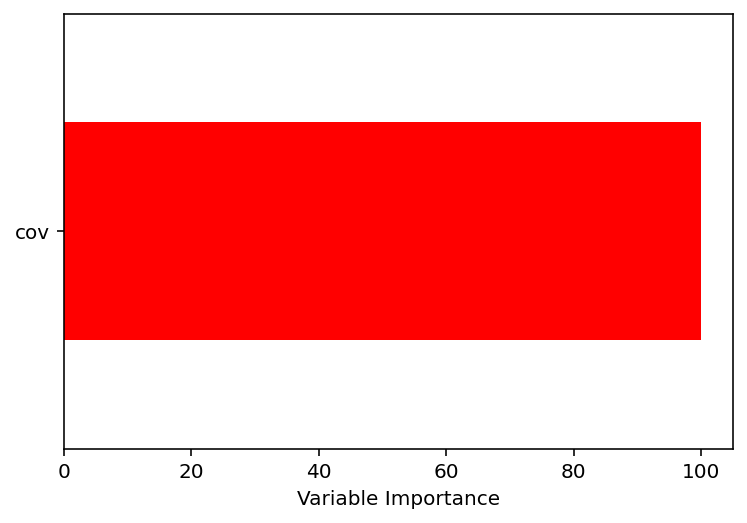

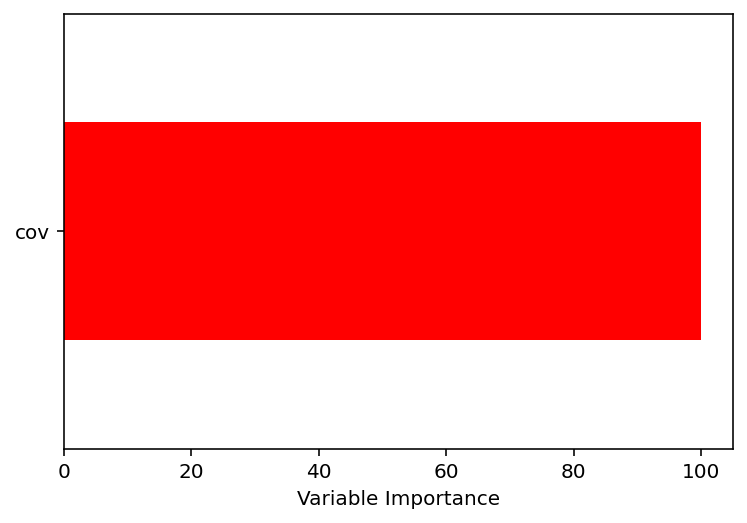

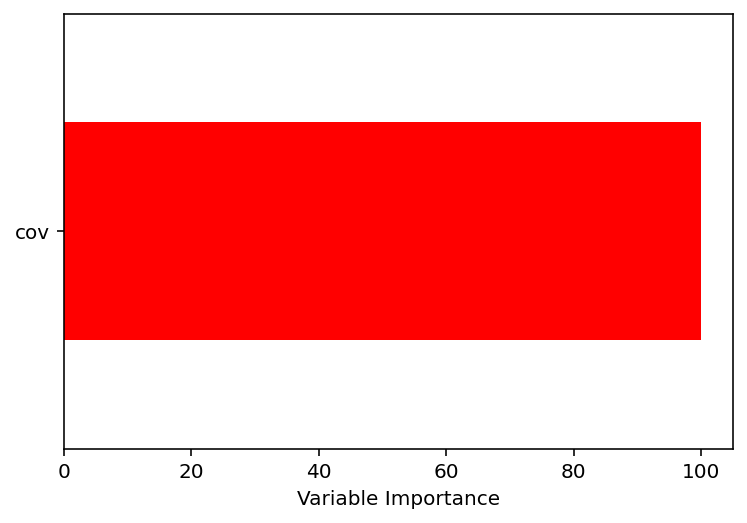

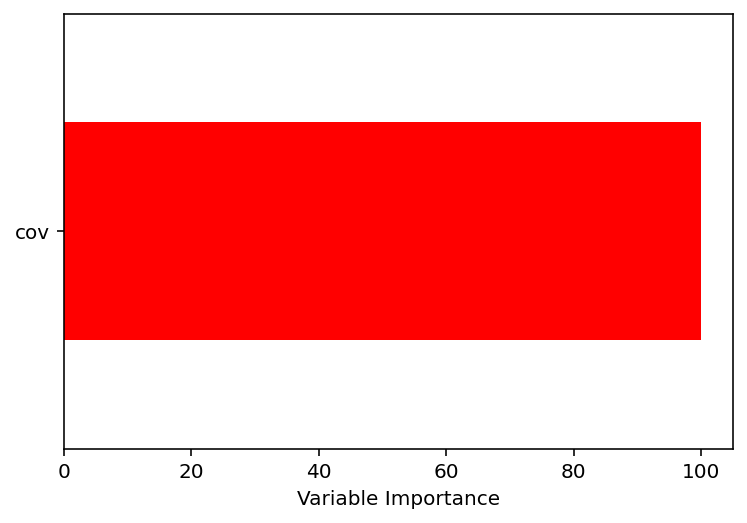

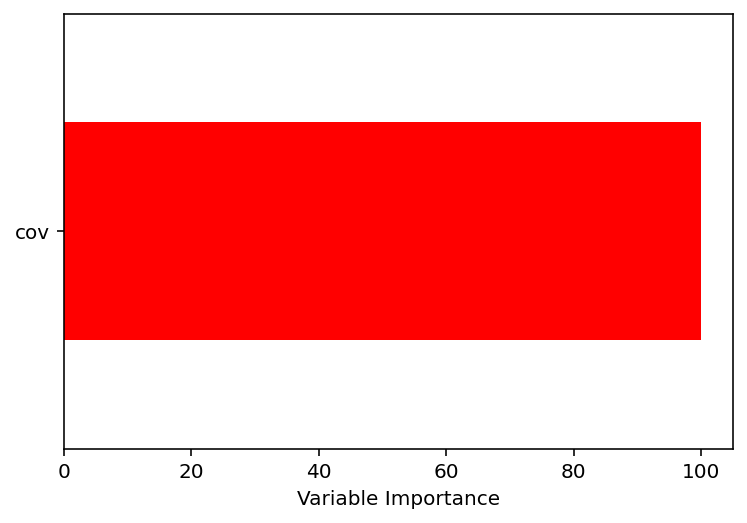

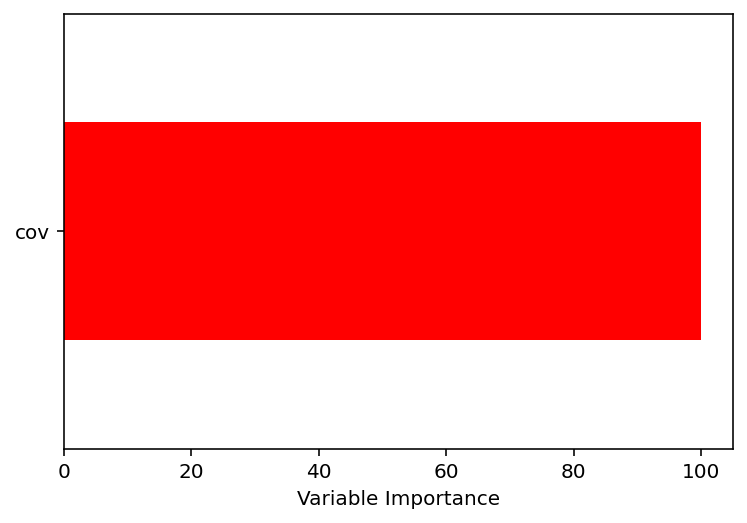

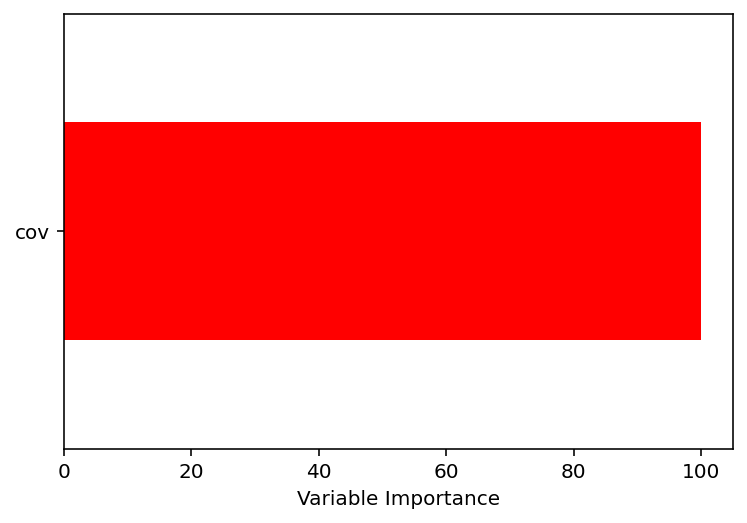

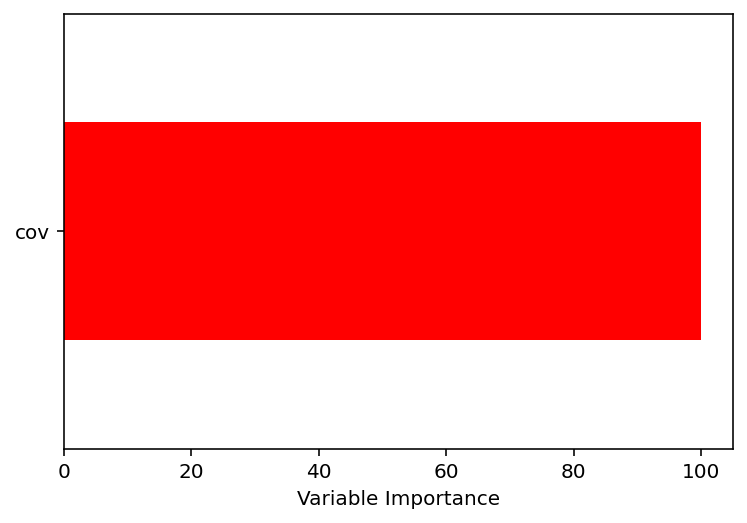

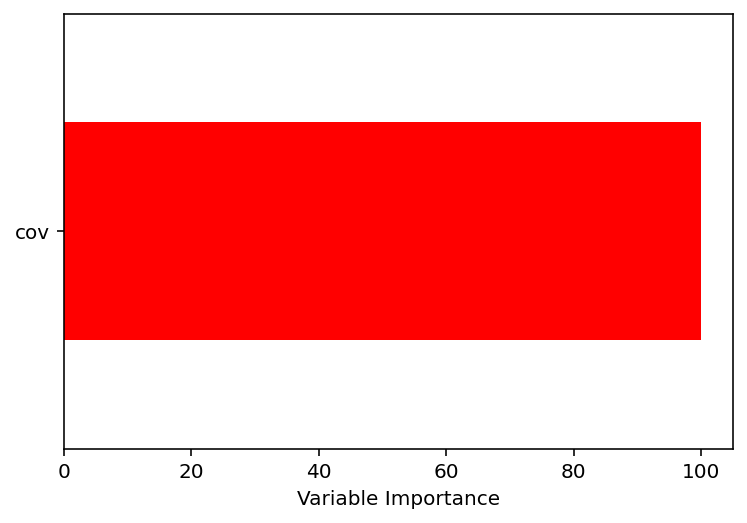

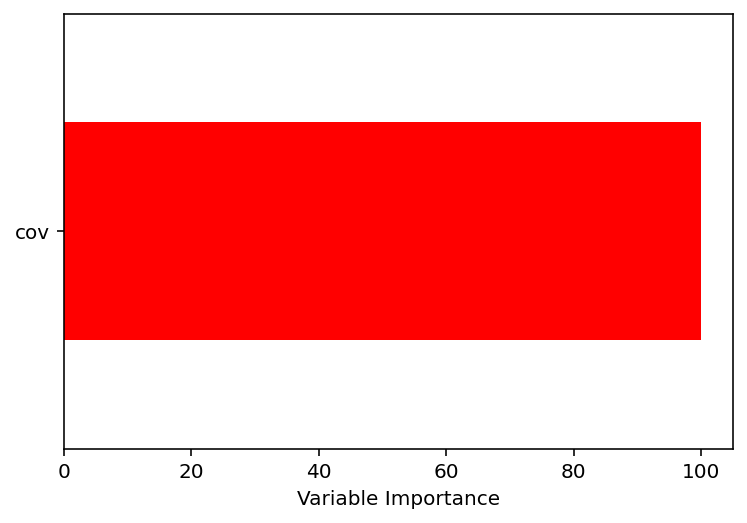

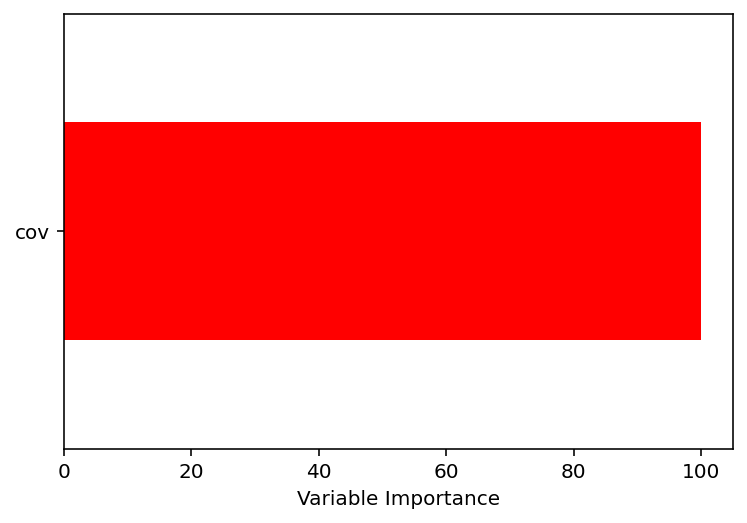

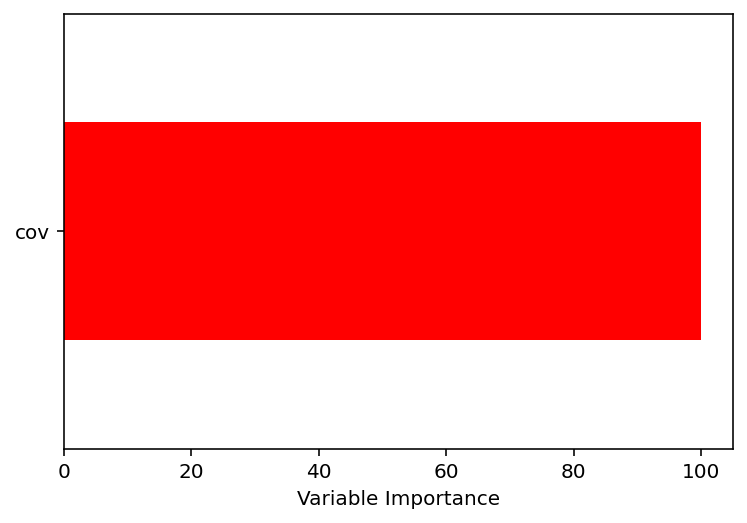

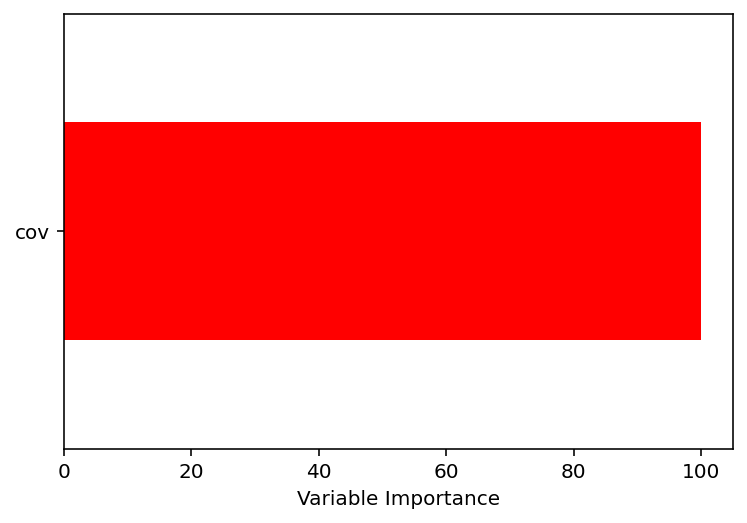

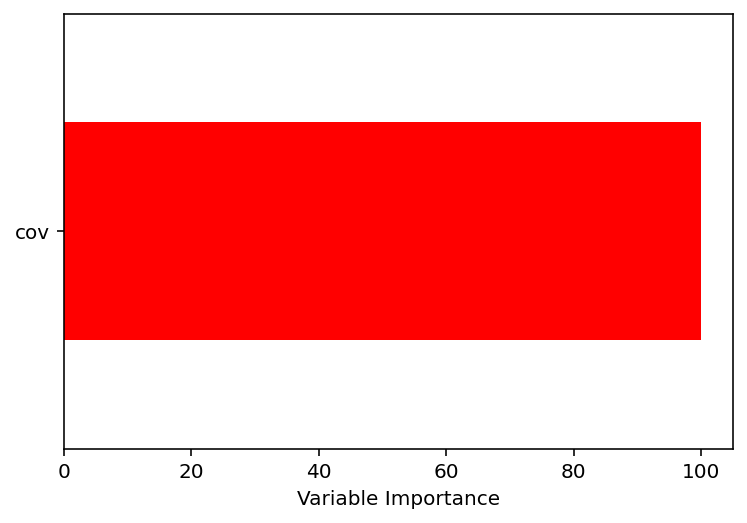

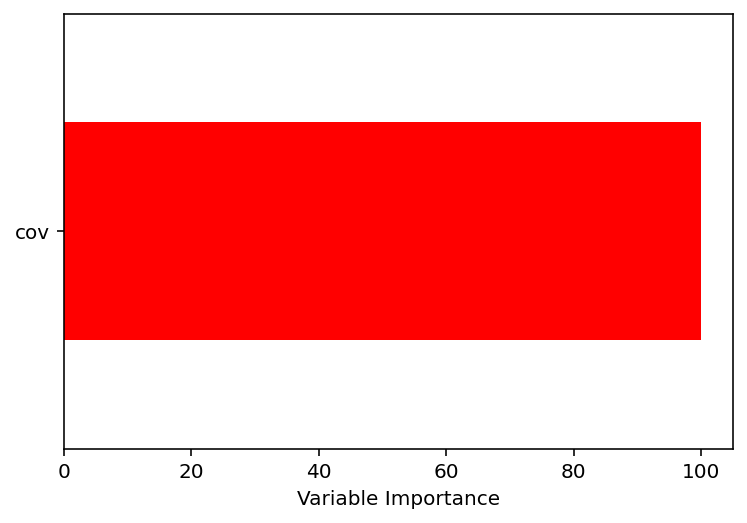

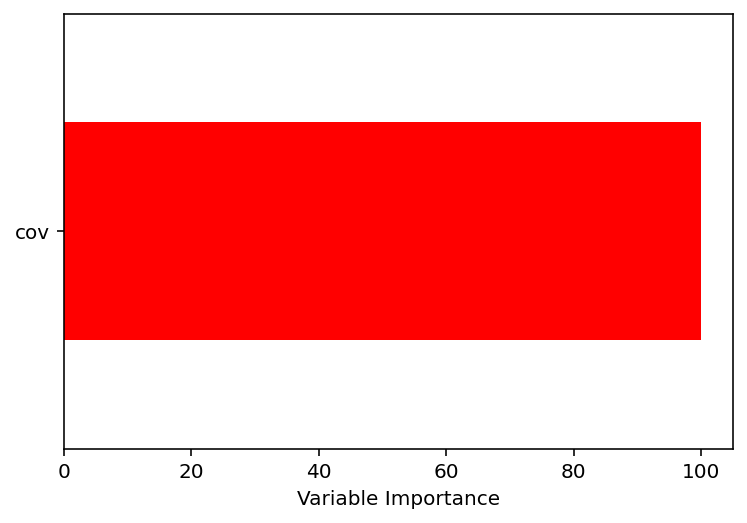

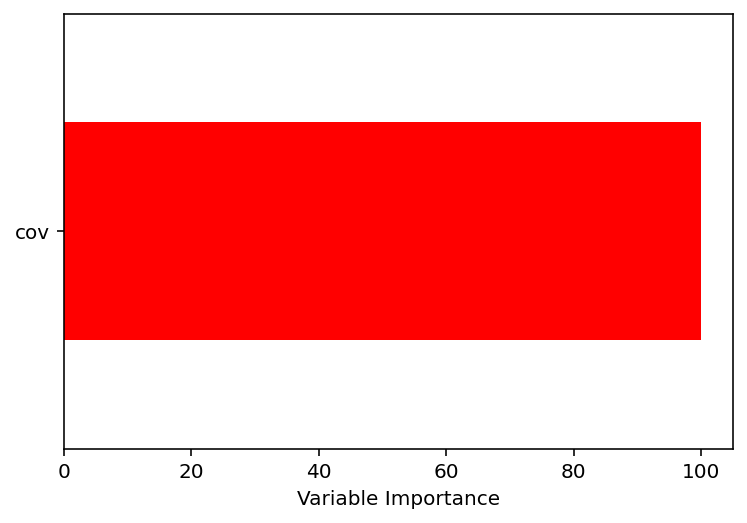

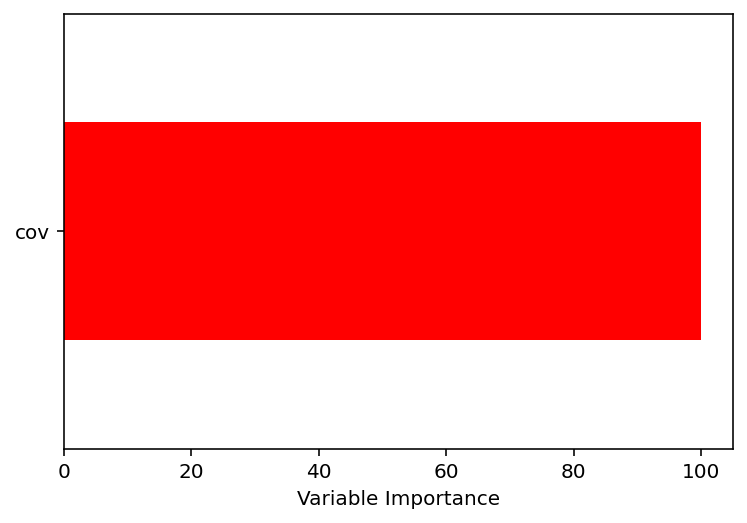

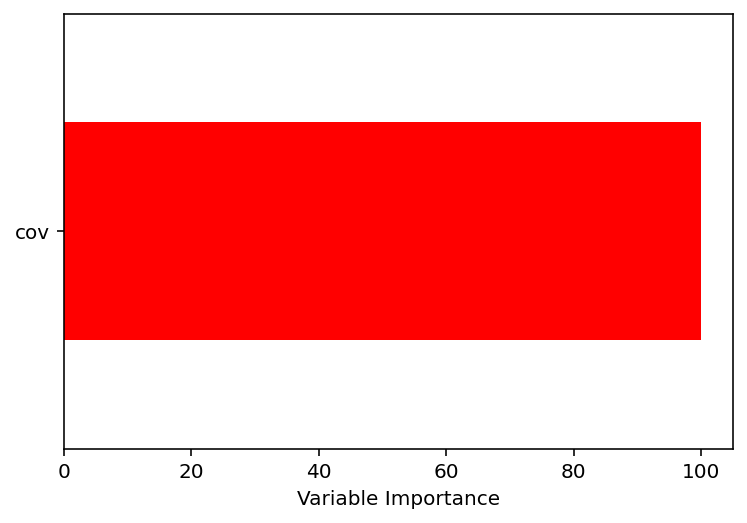

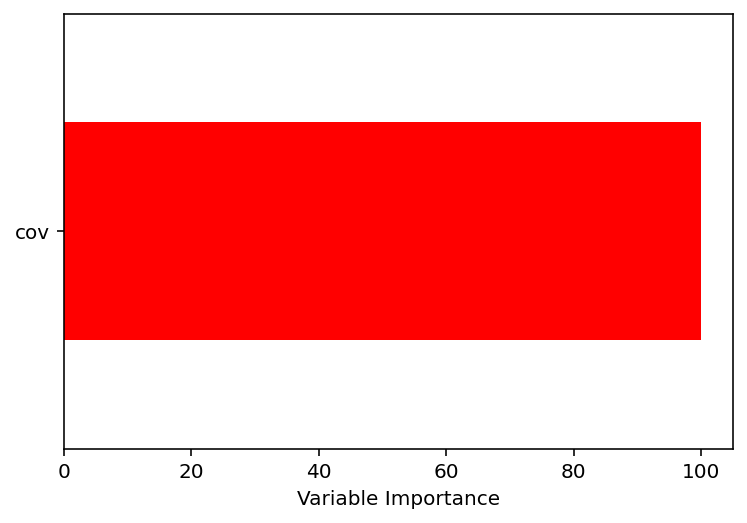

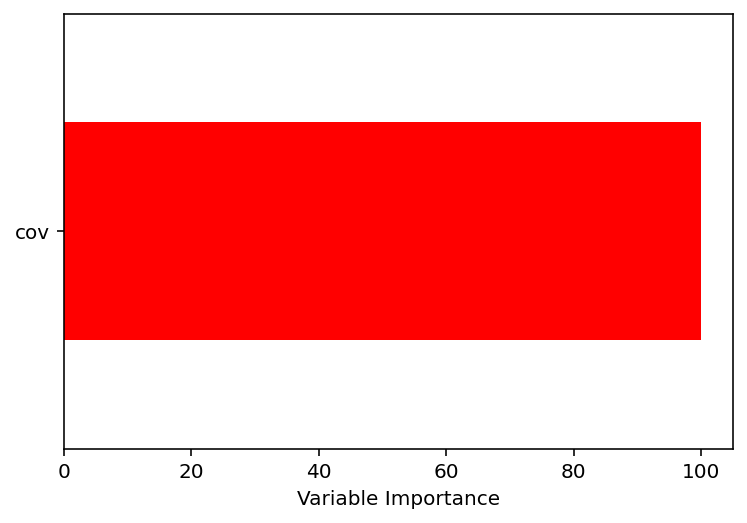

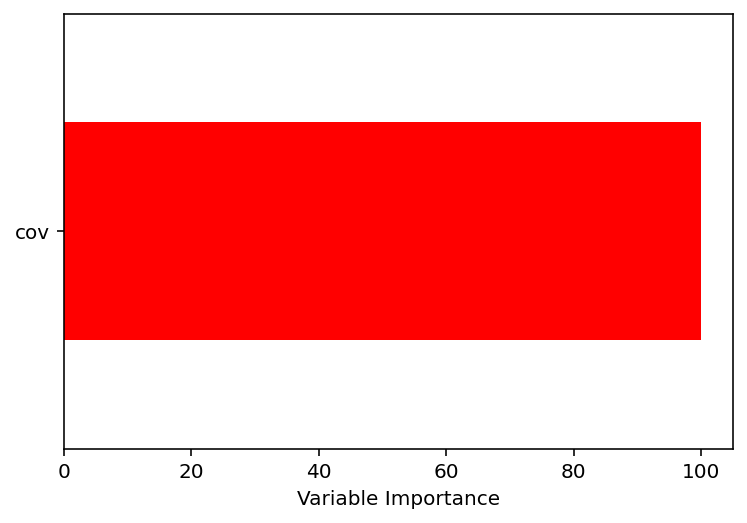

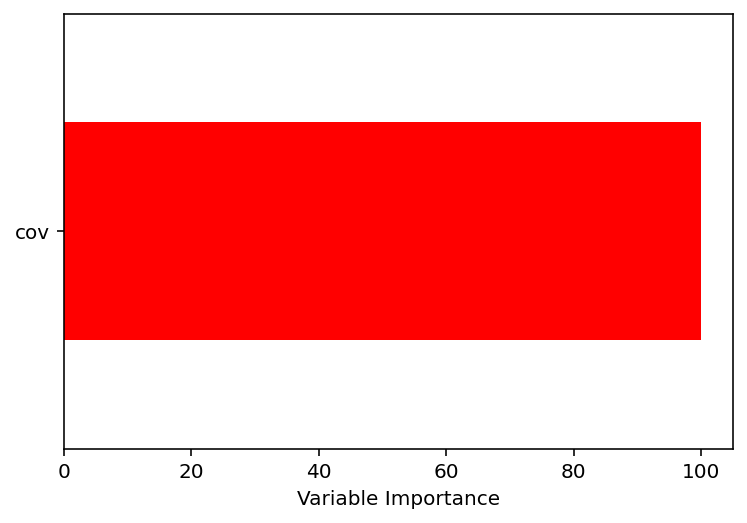

In [13]:
# LightGBM
lgbm = lightgbm.LGBMClassifier(learning_rate=0.09,max_depth=-5,random_state=42)

start_time = timeit.default_timer() #defines start time so computational time can be calculated

acc_score = []
Truth = []
Output = []
 
for train, test in tqdm(splits):
    X_train = X.iloc[train]
    y_train = y.iloc[train]

    X_test = X.iloc[test]
    y_test = y.iloc[test]
    
    # Create the LightGBM data containers
    model.fit(X_train,y_train,eval_set=[(X_test,y_test),(X_train,y_train)],
          eval_metric='logloss')

    pred_values = model.predict(X_test)
     
    acc = accuracy_score(y_test, pred_values)
    acc_score.append(acc)
    
    Truth.extend(y_test.values.reshape(y_test.shape[0])); ## it is a list
    Output.extend(pred_values); ## it is a list  
    
    #print(model.feature_importances_)
    Importance = pd.DataFrame({'Importance':(model.feature_importances_*100)[0:10]}, 
                          index = (X_train.columns)[0:10])
    Importance.sort_values(by = 'Importance', 
                       axis = 0, 
                       ascending = True).plot(kind = 'barh', 
                                              color = 'r')
    plt.xlabel('Variable Importance')
    plt.gca().legend_ = None
    #plt.savefig('plot1.png')


elapsed = timeit.default_timer() - start_time #gives total computation time
print("---Run time is %s seconds ---" % elapsed) #prints computation time
print()

print('Accuracy of each fold: \n {}'.format(acc_score))
print()
print('Avg accuracy : \n{}'.format(np.mean(acc_score))); 
print()
print('Std of accuracy : \n{}'.format(np.std(acc_score)))

cm = confusion_matrix(Truth, Output)
print(cm)
print("classification report: ")
print(classification_report(Truth, Output))

sensitivity = cm[0][0]/(cm[0][0]+cm[0][1])
specificity = cm[1][1]/(cm[1][0]+cm[1][1])
precision = (cm[0][0])/(cm[0][0]+cm[1][0])
f1_score = (2*precision*sensitivity)/(precision+sensitivity)

performance_dict['Avg Accuracy'].append(np.mean(acc_score))
performance_dict['Std Accuracy'].append(np.std(acc_score))
performance_dict['Sensitivity'].append(sensitivity)
performance_dict['Specificity'].append(specificity)
performance_dict['Precision'].append(precision)
performance_dict['F1 score'].append(f1_score)
performance_dict['Run time'].append(elapsed)

 87%|███████████████████████████████████████████████████████████████████████▎          | 20/23 [00:10<00:01,  1.91it/s]C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\pandas\plotting\_matplotlib\core.py:386: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)
100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:12<00:00,  1.91it/s]


---Run time is 12.030841100000544 seconds ---

Accuracy of each fold: 
 [0.8764183185235817, 0.9209785457722551, 0.987028657616893, 0.7185569904548007, 0.9908302977012938, 0.9163990267639903, 0.9076440260031383, 0.9616958585693239, 0.9310427968655817, 0.7238736953362399, 0.9676153091265947, 0.9618109555901158, 0.8167755991285403, 0.9607722954336501, 0.28618453865336657, 0.9436619718309859, 0.911272968051647, 0.9936155447605829, 0.5195700669235449, 0.9447674418604651, 0.9859054233479726, 0.9226819691935971, 0.9931354734504341]

Avg accuracy : 
0.8757494683025474

Std of accuracy : 
0.1670995475502685
[[87088 15797]
 [ 9260 75412]]
classification report: 
              precision    recall  f1-score   support

           0       0.90      0.85      0.87    102885
           1       0.83      0.89      0.86     84672

    accuracy                           0.87    187557
   macro avg       0.87      0.87      0.87    187557
weighted avg       0.87      0.87      0.87    187557



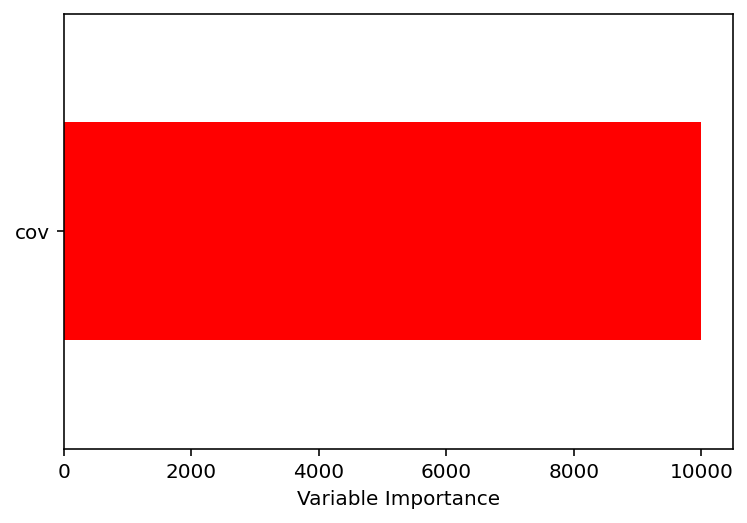

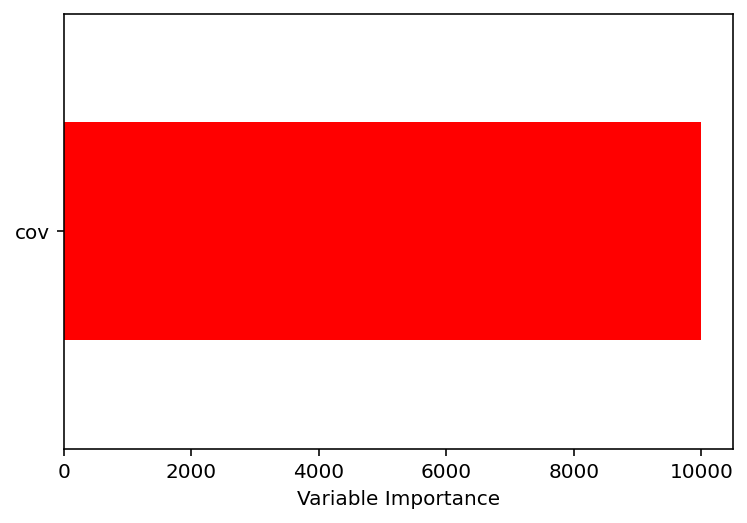

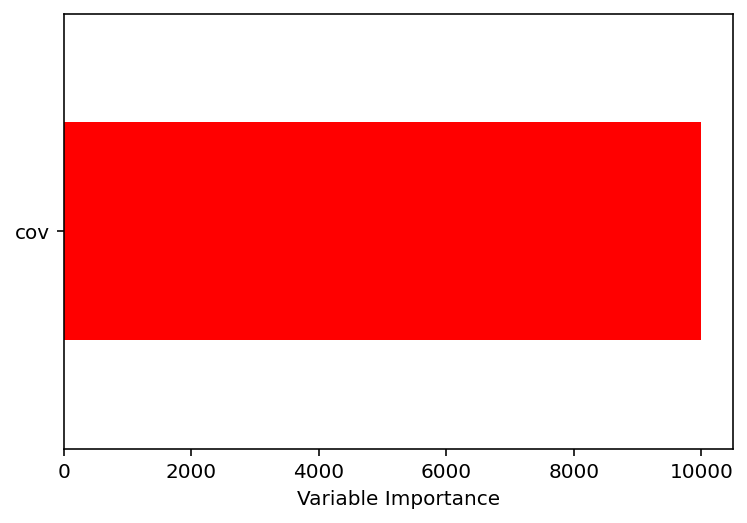

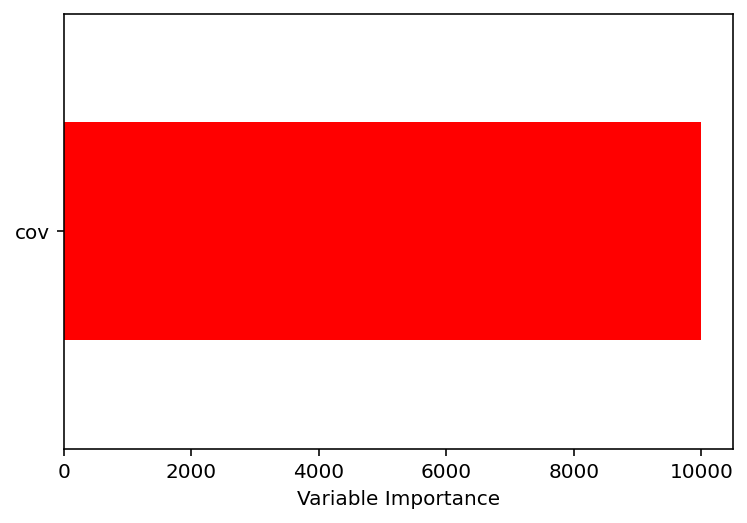

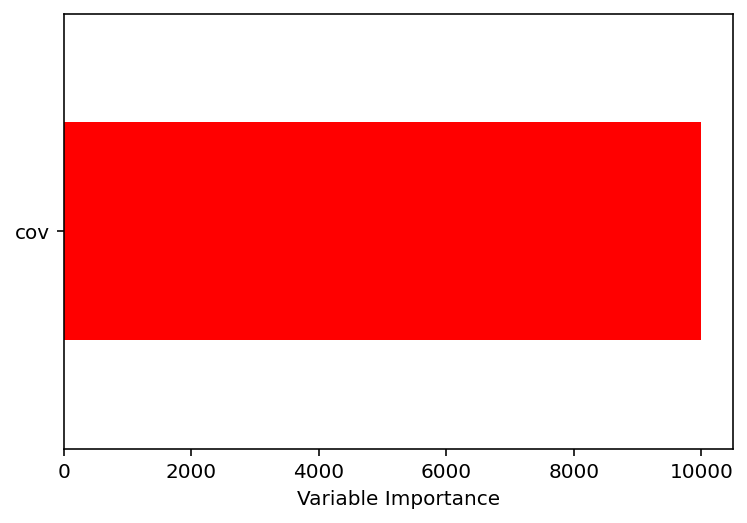

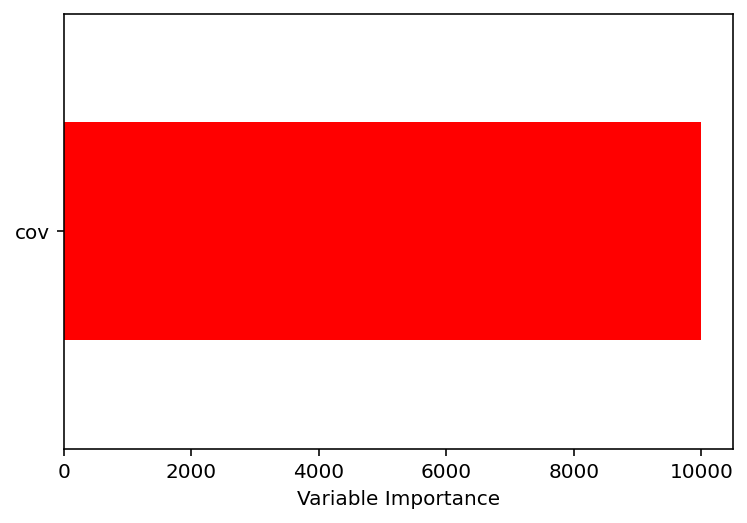

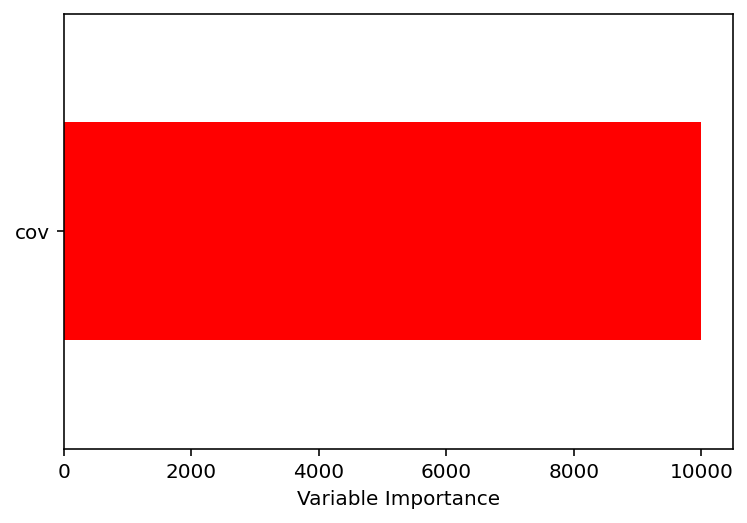

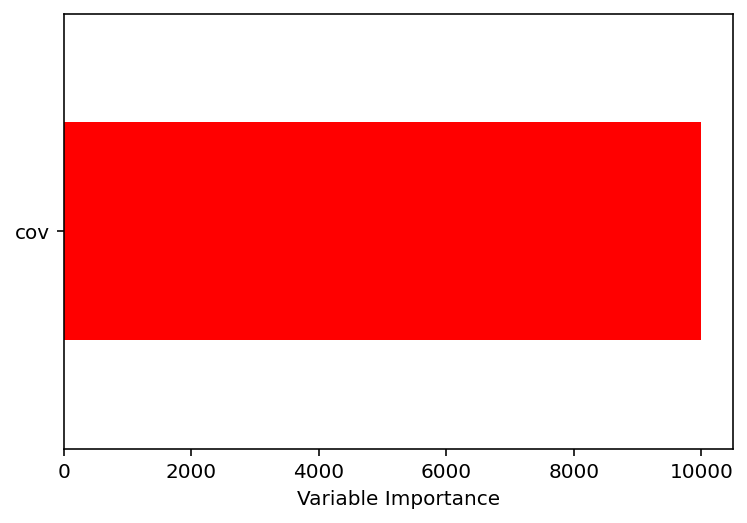

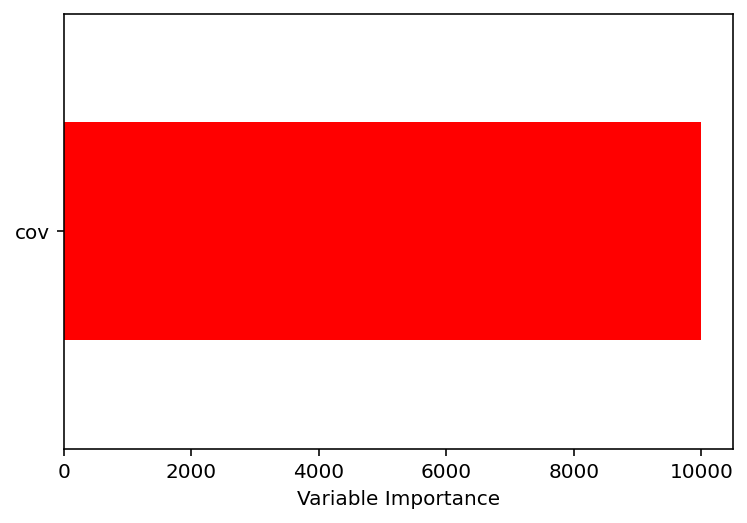

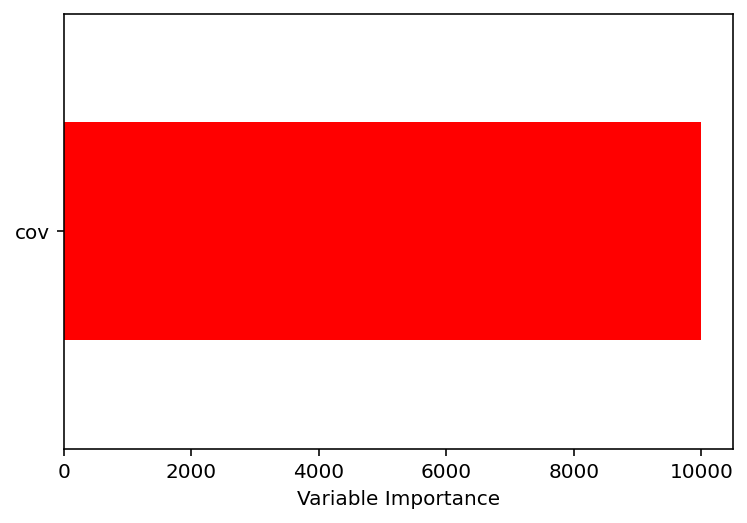

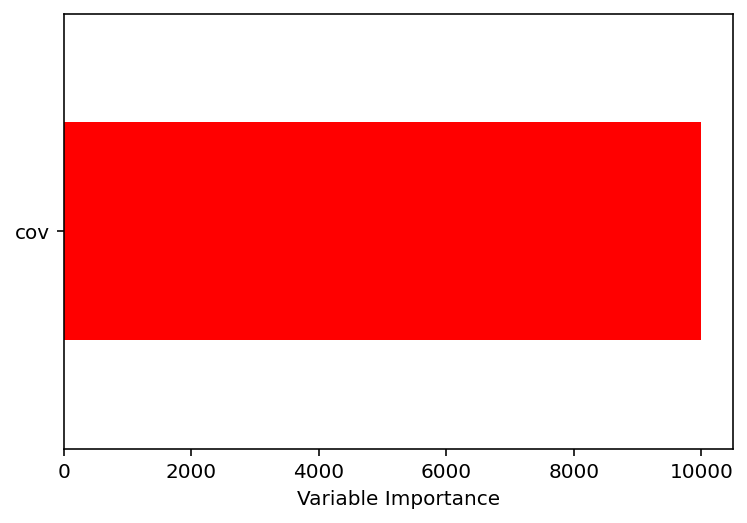

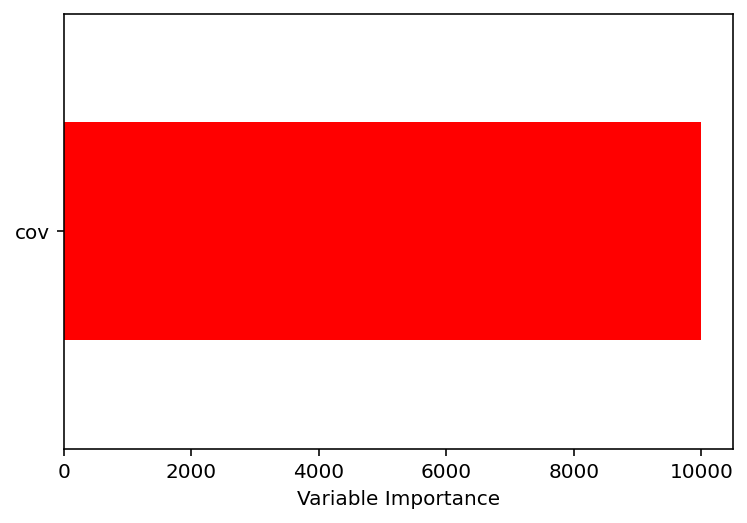

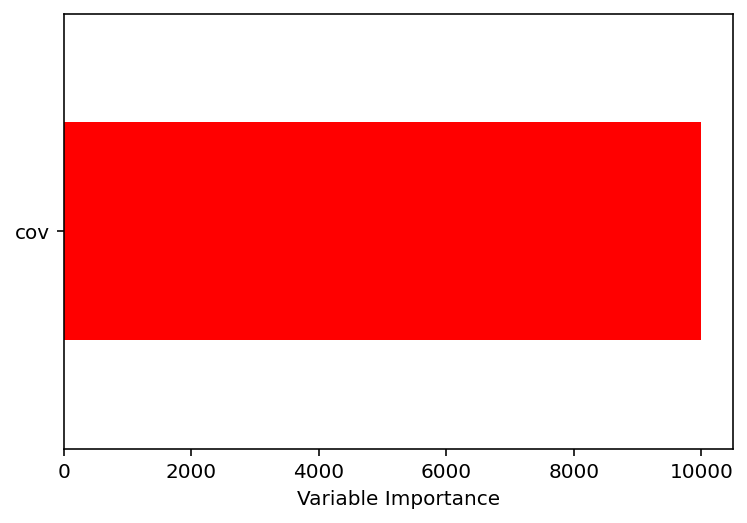

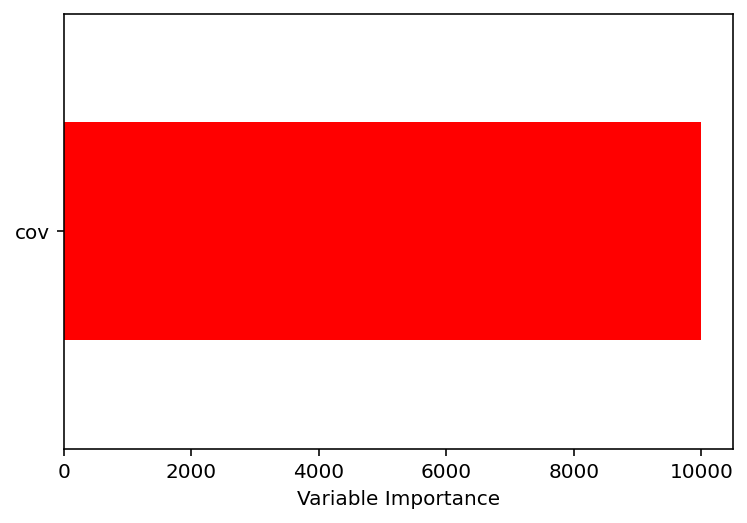

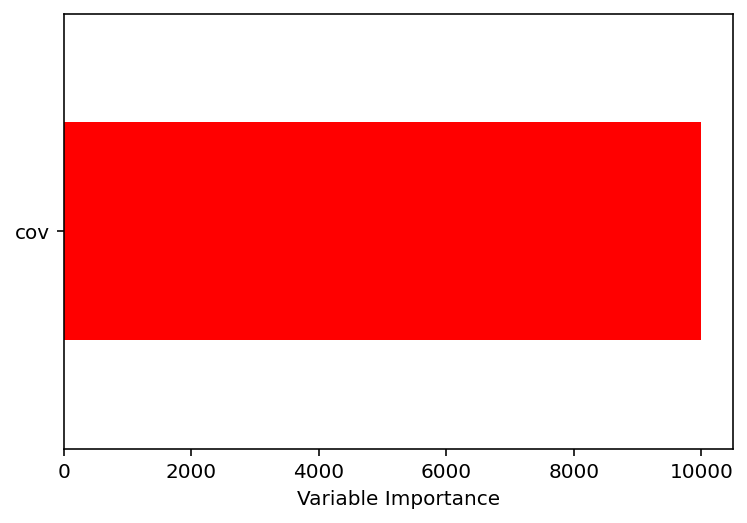

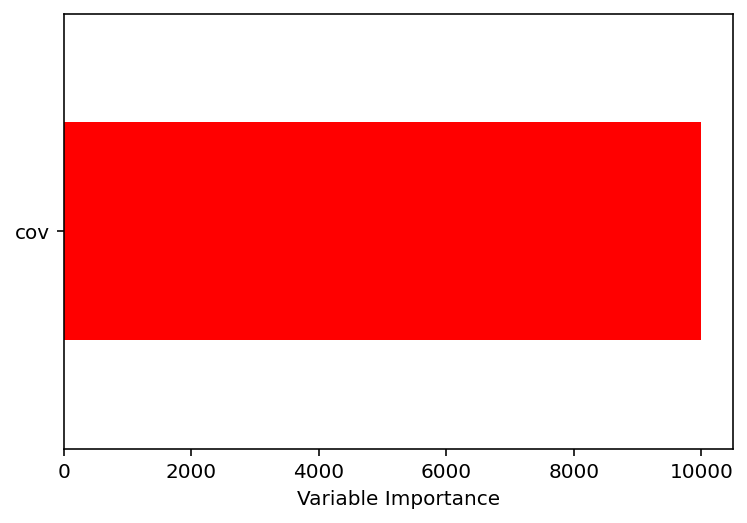

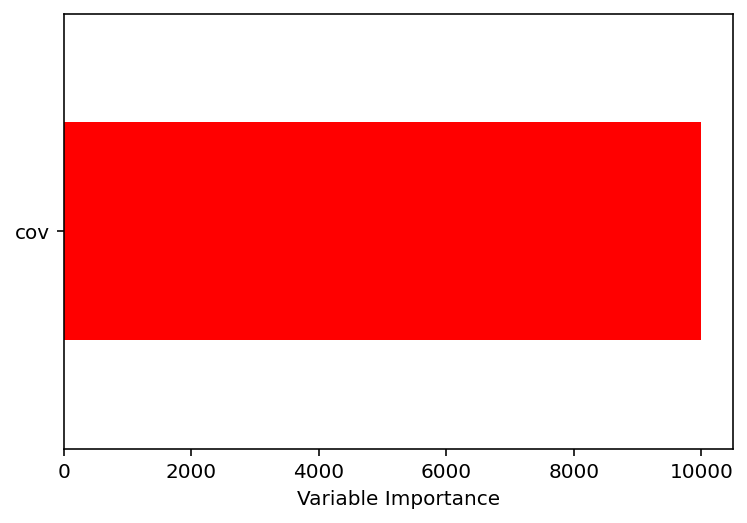

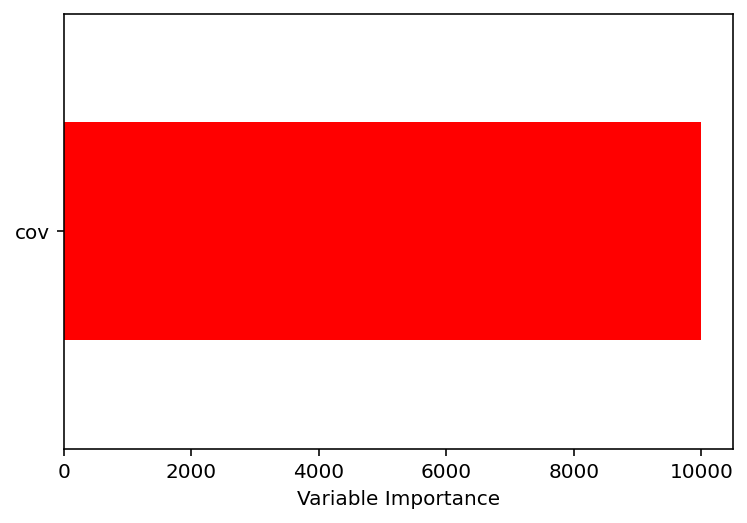

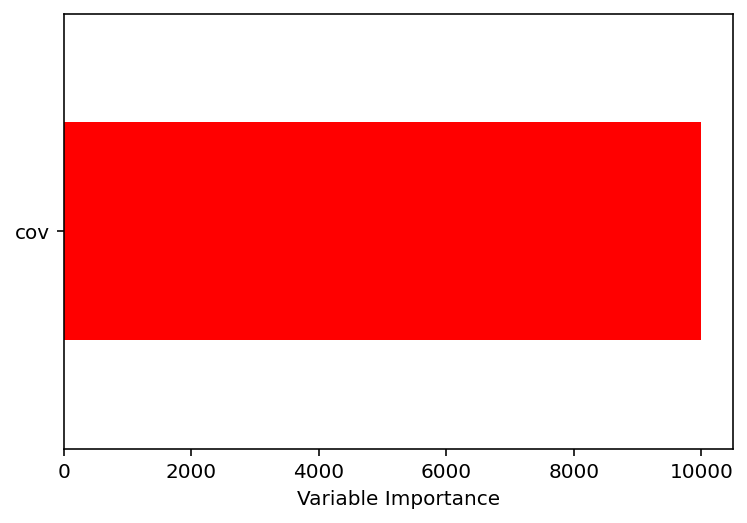

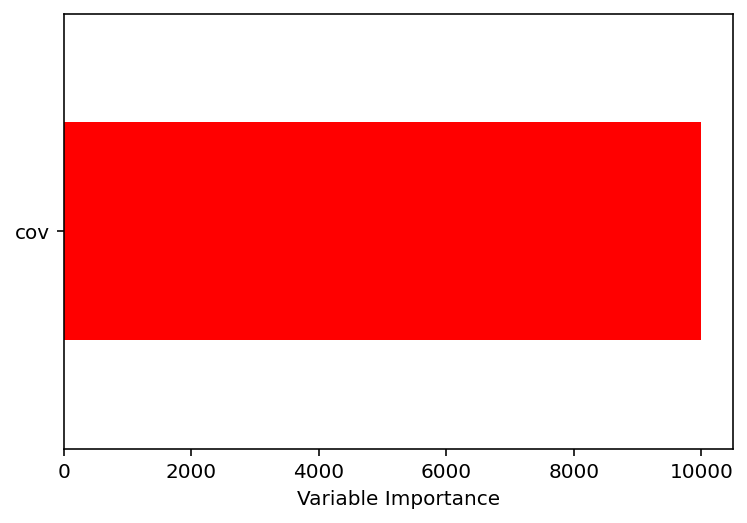

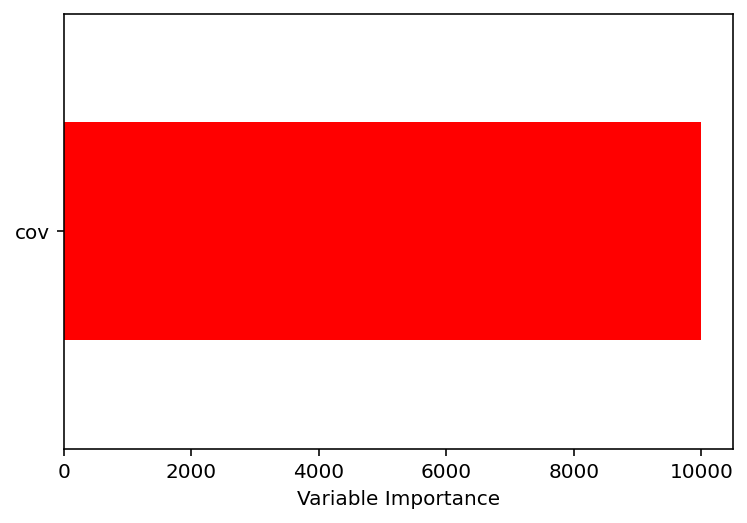

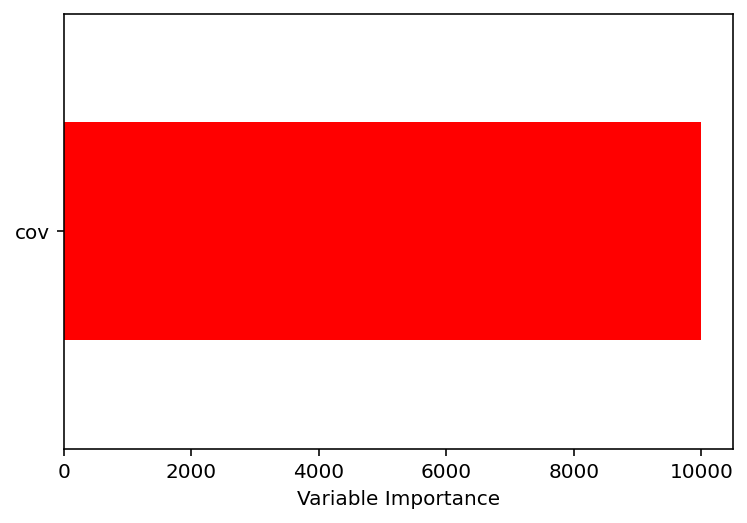

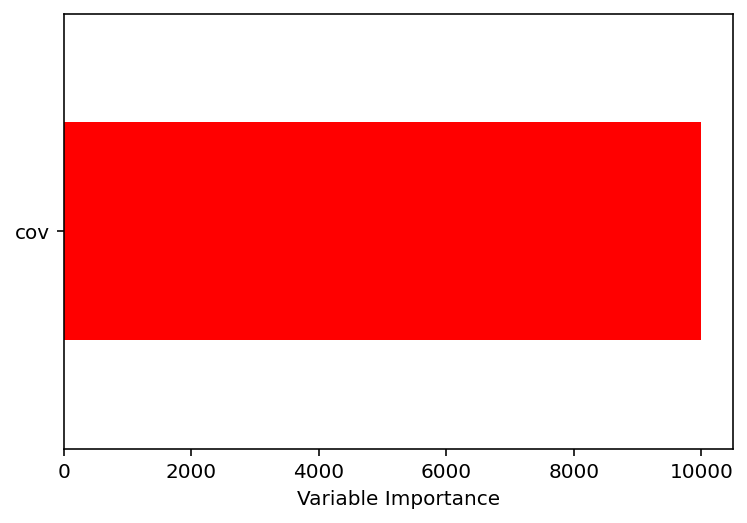

In [14]:
# CatBoost
start_time = timeit.default_timer() #defines start time so computational time can be calculated

acc_score = []
Truth = []
Output = []
 
for train, test in tqdm(splits):
    X_train = X.iloc[train]
    y_train = y.iloc[train]

    X_test = X.iloc[test]
    y_test = y.iloc[test]
    
    # Create CatBoost model
    model = CatBoostClassifier(iterations=100,
                           depth=4,
                           learning_rate=0.1,
                           loss_function='Logloss')
    # train the model
    model.fit(X_train, y_train, verbose=False)
    
    # make the prediction using the resulting model
    pred_values = model.predict(X_test)
    #preds_proba = model.predict_proba(test_data)
    #print("class = ", preds_class)
    #print("proba = ", preds_proba)
     
    acc = accuracy_score(y_test, pred_values)
    acc_score.append(acc)
    
    Truth.extend(y_test.values.reshape(y_test.shape[0])); ## it is a list
    Output.extend(pred_values); ## it is a list  
    
    #print(model.feature_importances_)
    Importance = pd.DataFrame({'Importance':(model.feature_importances_*100)[0:10]}, 
                          index = (X_train.columns)[0:10])
    Importance.sort_values(by = 'Importance', 
                       axis = 0, 
                       ascending = True).plot(kind = 'barh', 
                                              color = 'r')
    plt.xlabel('Variable Importance')
    plt.gca().legend_ = None
    #plt.savefig('plot1.png')


elapsed = timeit.default_timer() - start_time #gives total computation time
print("---Run time is %s seconds ---" % elapsed) #prints computation time
print()

print('Accuracy of each fold: \n {}'.format(acc_score))
print()
print('Avg accuracy : \n{}'.format(np.mean(acc_score))); 
print()
print('Std of accuracy : \n{}'.format(np.std(acc_score)))

cm = confusion_matrix(Truth, Output)
print(cm)
print("classification report: ")
print(classification_report(Truth, Output))

sensitivity = cm[0][0]/(cm[0][0]+cm[0][1])
specificity = cm[1][1]/(cm[1][0]+cm[1][1])
precision = (cm[0][0])/(cm[0][0]+cm[1][0])
f1_score = (2*precision*sensitivity)/(precision+sensitivity)

performance_dict['Avg Accuracy'].append(np.mean(acc_score))
performance_dict['Std Accuracy'].append(np.std(acc_score))
performance_dict['Sensitivity'].append(sensitivity)
performance_dict['Specificity'].append(specificity)
performance_dict['Precision'].append(precision)
performance_dict['F1 score'].append(f1_score)
performance_dict['Run time'].append(elapsed)

In [15]:
performance_df = pd.DataFrame(performance_dict)
performance_df

,Avg Accuracy,Std Accuracy,Sensitivity,Specificity,Precision,F1 score,Run time
0,0.900440,0.114618,0.846829,0.974090,0.980144,0.908623,82.344071
1,0.876760,0.168585,0.846829,0.892078,0.905074,0.874983,99.135414
2,0.875749,0.167100,0.846460,0.890637,0.903890,0.874233,12.030841
